In [1]:
import subprocess
import sys
from tqdm import tqdm

print("⏳ Checking and installing all required dependencies for the experiment...")

def install(package_list, is_torch_stack=False):
    """
    Installs a list of packages using pip.
    For the PyTorch stack, it uses a specific index URL.
    """
    try:
        command = [sys.executable, "-m", "pip", "install", "--quiet"]
        if is_torch_stack:
            command.extend(["--index-url", "https://download.pytorch.org/whl/cu121"])
        
        command.extend(package_list)
        subprocess.check_call(command)
        return True
    except subprocess.CalledProcessError as e:
        print(f"\n❌ Failed to install {' '.join(package_list)}. Error: {e}")
        return False

try:
    # Step 1: Clean up any existing conflicting installations for a clean slate.
    print("\n[Step 1/4] Cleaning up existing PyTorch installations...")
    subprocess.run([sys.executable, "-m", "pip", "uninstall", "-y",
                    "torch", "torchvision", "torchaudio", "torchtext", "torchdata"],
                   capture_output=True)

    # Step 2: Install the entire PyTorch stack in a single command.
    # This is the most robust way to ensure CUDA version compatibility across all packages.
    print("\n[Step 2/4] Installing PyTorch, Torchvision, and Torchaudio for CUDA 12.1...")
    
    # We install torch, torchvision, and torchaudio together to ensure pip resolves
    # their dependencies correctly for the specified CUDA version.
    torch_stack = [
        "torch==2.1.1",
        "torchvision==0.16.1",
        "torchaudio==2.1.1"
    ]
    if not install(torch_stack, is_torch_stack=True):
        print("   -> Critical PyTorch installation failed. Aborting.")
        sys.exit(1)
    
    # Step 3: Install the remaining, non-CUDA-dependent PyTorch ecosystem packages.
    print("\n[Step 3/4] Installing remaining Torch ecosystem packages...")
    torch_ecosystem_packages = [
        ["torchtext==0.16.1"],
        ["torchdata==0.7.1"]
    ]
    for package in tqdm(torch_ecosystem_packages, desc="Installing Torch ecosystem"):
        if not install(package):
            sys.exit(1)
            
    # Step 4: Install all other scientific computing packages.
    print("\n[Step 4/4] Installing basic scientific packages...")
    basic_packages = [
        ["numpy==1.26.0"], ["pandas==2.1.1"], ["scikit-learn==1.3.2"],
        ["scipy==1.11.3"], ["matplotlib==3.8.0"], ["seaborn==0.13.0"],
        ["statsmodels==0.14.1"], ["tqdm==4.66.1"]
    ]
    for package in tqdm(basic_packages, desc="Installing basic packages"):
        if not install(package):
            sys.exit(1)

    print("\n✅ All specified dependencies are installed.")

except Exception as e:
    print(f"❌ An unexpected error occurred during installation: {e}")
    sys.exit(1)

# --- Final Verification Step ---
try:
    print("\n🔍 Testing library imports...")
    import numpy, pandas, torch, torchvision, torchtext, torchaudio, torchdata
    import sklearn, scipy, matplotlib, seaborn, statsmodels
    import tqdm as TQDM

    print("\n✅ Setup complete! Library versions:")
    print(f"   - NumPy:        {numpy.__version__}")
    print(f"   - Pandas:       {pandas.__version__}")
    print(f"   - PyTorch:      {torch.__version__}")
    print(f"   - Torchvision:  {torchvision.__version__}")
    print(f"   - Torchaudio:   {torchaudio.__version__}")
    print(f"   - Scikit-learn: {sklearn.__version__}")
    print(f"   - Statsmodels:  {statsmodels.__version__}")
    
    print(f"\n🔧 PyTorch Configuration:")
    cuda_available = torch.cuda.is_available()
    print(f"   - CUDA Available:    {'✓ Yes' if cuda_available else '✗ No'}")
    if cuda_available:
        print(f"   - CUDA Device Count: {torch.cuda.device_count()}")
        print(f"   - Current Device:    {torch.cuda.current_device()}")
        print(f"   - Device Name:       {torch.cuda.get_device_name(0)}")
        # This check is now internal to the verification step.
        torchvision.ops.nms(torch.rand(1,4).cuda(), torch.rand(1).cuda(), 0.5)
        print("   - Torchvision CUDA linkage: ✓ Verified")


except ImportError as e:
    print(f"\n❌ Critical library import failed: {e}")
    sys.exit(1)
except Exception as e:
    print(f"\n❌ Unexpected error during testing: {e}")
    sys.exit(1)

print("\n🎉 Environment setup completed successfully!")
print("You can now run your machine learning experiments.")

⏳ Checking and installing all required dependencies for the experiment...

[Step 1/4] Cleaning up existing PyTorch installations...

[Step 2/4] Installing PyTorch, Torchvision, and Torchaudio for CUDA 12.1...



[Step 3/4] Installing remaining Torch ecosystem packages...


Installing Torch ecosystem: 100%|██████████| 2/2 [00:04<00:00,  2.47s/it]



[Step 4/4] Installing basic scientific packages...


Installing basic packages: 100%|██████████| 8/8 [00:41<00:00,  5.20s/it]



✅ All specified dependencies are installed.

🔍 Testing library imports...

✅ Setup complete! Library versions:
   - NumPy:        1.26.0
   - Pandas:       2.1.1
   - PyTorch:      2.1.1+cu121
   - Torchvision:  0.16.1+cu121
   - Torchaudio:   2.1.1+cu121
   - Scikit-learn: 1.3.2
   - Statsmodels:  0.14.1

🔧 PyTorch Configuration:
   - CUDA Available:    ✓ Yes
   - CUDA Device Count: 1
   - Current Device:    0
   - Device Name:       NVIDIA RTX A6000
   - Torchvision CUDA linkage: ✓ Verified

🎉 Environment setup completed successfully!
You can now run your machine learning experiments.


In [3]:
# ===================================================================
#
#       Definitive Script for RG-Flow Stability Analysis (Phase 1)
#
# This script uses a flexible, configuration-driven approach to test
# if macro-architectural properties can predict signal stability (sigma)
# in various neural network families.
#
# ===================================================================

import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from tqdm import tqdm
from thop import profile
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from collections import defaultdict
import warnings

# --- Global Setup ---
torch.set_num_threads(1)
warnings.filterwarnings("ignore", category=UserWarning, module="thop")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# ===================================================================
#  Part 1: Core Utilities and Model Definitions
# ===================================================================
# (This entire section is unchanged. All model and utility function
# definitions remain the same as the previous version.)

def set_random_seed(seed: int) -> None:
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

_ds_cache = {}
def get_data(ds_name: str, resize: int) -> datasets.VisionDataset:
    key = (ds_name, resize)
    if key not in _ds_cache:
        DataClass = datasets.CIFAR10 if ds_name == 'cifar' else datasets.MNIST
        tf = transforms.Compose([transforms.Resize((resize, resize)), transforms.ToTensor()])
        _ds_cache[key] = DataClass('./data', train=False, download=True, transform=tf)
    return _ds_cache[key]

class ModularCNN(nn.Module):
    def __init__(self, conv_channels: list, kernel_sizes: list, strides: list, use_batchnorm: bool, in_channels: int = 3):
        super().__init__()
        self.convs, self.bns = nn.ModuleList(), nn.ModuleList() if use_batchnorm else None
        self.use_bn = use_batchnorm; self.strides, self.kernel_sizes = strides, kernel_sizes
        for out_ch, k in zip(conv_channels, kernel_sizes):
            self.convs.append(nn.Conv2d(in_channels, out_ch, kernel_size=k, padding=k//2))
            if self.use_bn: self.bns.append(nn.BatchNorm2d(out_ch))
            in_channels = out_ch
    def forward(self, x: torch.Tensor) -> list[torch.Tensor]:
        activations = []
        for i, conv in enumerate(self.convs):
            x = conv(x)
            if self.use_bn: x = self.bns[i](x)
            x = F.relu(x); activations.append(x.clone())
            if self.strides[i] > 1: x = F.avg_pool2d(x, kernel_size=self.strides[i])
        return activations

class ResNetBlock(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1, kernel_size=3, bottleneck_ratio=1.0, projection_type='identity', activation='relu'):
        super().__init__()
        mid_ch = int(out_ch * bottleneck_ratio)
        self.conv1, self.bn1 = nn.Conv2d(in_ch, mid_ch, kernel_size, stride, kernel_size//2, bias=False), nn.BatchNorm2d(mid_ch)
        self.conv2, self.bn2 = nn.Conv2d(mid_ch, out_ch, kernel_size, 1, kernel_size//2, bias=False), nn.BatchNorm2d(out_ch)
        if projection_type == 'conv1x1' or stride != 1 or in_ch != out_ch: self.shortcut = nn.Sequential(nn.Conv2d(in_ch, out_ch, 1, stride, bias=False), nn.BatchNorm2d(out_ch))
        else: self.shortcut = nn.Identity()
        self.act = F.leaky_relu if activation == 'leaky_relu' else F.relu
    def forward(self, x):
        y = self.act(self.bn1(self.conv1(x))); y = self.bn2(self.conv2(y)); y += self.shortcut(x); return self.act(y)

class ModularResNet(nn.Module):
    def __init__(self, channels, block_sizes, kernel_sizes, strides, bottleneck_ratios, projection_types, activation_functions, in_channels=3):
        super().__init__()
        self.channels, self.block_sizes, self.kernel_sizes, self.strides = channels, block_sizes, kernel_sizes, strides
        self.bottleneck_ratios, self.projection_types, self.activation_functions = bottleneck_ratios, projection_types, activation_functions
        self.conv1, self.bn1 = nn.Conv2d(in_channels, channels[0], kernel_size=3, stride=1, padding=1, bias=False), nn.BatchNorm2d(channels[0])
        self.in_ch = channels[0]
        self.layers = nn.ModuleList([self._make_layer(i) for i in range(len(channels))])
    def _make_layer(self, stage_idx):
        out_ch, num_blocks, s, k = self.channels[stage_idx], self.block_sizes[stage_idx], self.strides[stage_idx], self.kernel_sizes[stage_idx]
        br, pt, af = self.bottleneck_ratios[stage_idx], self.projection_types[stage_idx], self.activation_functions[stage_idx]
        blocks = []
        for i, block_stride in enumerate([s] + [1]*(num_blocks-1)):
            current_pt = pt if i == 0 else 'identity'
            blocks.append(ResNetBlock(self.in_ch, out_ch, block_stride, k, br, current_pt, af))
            self.in_ch = out_ch
        return nn.Sequential(*blocks)
    def forward(self, x):
        acts, x = [], F.relu(self.bn1(self.conv1(x)))
        for stage in self.layers:
            for block in stage: x = block(x); acts.append(x.clone())
        return acts


# ===================================================================
# Part 2: Architecture Generation and Property Extraction
# ===================================================================

def _generate_random_cnn(n_layers: int, param_ranges: dict, use_batchnorm: bool, input_size: int, in_channels: int) -> ModularCNN:
    """Internal generator for ModularCNN."""
    size, channels, kernels, strides = input_size, [], [], []
    for _ in range(n_layers):
        s, k, c = random.choice([st for st in param_ranges['strides'] if size // st >= 1] or [1]), random.choice(param_ranges['kernels']), random.choice(param_ranges['channels'])
        strides.append(s); kernels.append(k); channels.append(c); size //= s
    return ModularCNN(channels, kernels, strides, use_batchnorm, in_channels)

def _generate_random_resnet(target_total_blocks: int, param_ranges: dict, input_size: int, in_channels: int) -> ModularResNet:
    """Internal generator for ModularResNet."""
    num_stages = 4
    blocks_per_stage = [target_total_blocks // num_stages] * num_stages
    for i in range(target_total_blocks % num_stages): blocks_per_stage[i] += 1
    size, channels, ks, strides, brs, pts, afs = input_size, [], [], [], [], [], []
    for i in range(min(num_stages, target_total_blocks)):
        if size <= 1: break
        c, k, s, br, pt, af = [random.choice(param_ranges[key]) for key in ['channels', 'kernel_sizes', 'strides', 'bottleneck_ratios', 'projection_types', 'activation_functions']]
        if size // s < 1: s = 1
        channels.append(c); ks.append(k); strides.append(s); brs.append(br); pts.append(pt); afs.append(af); size //= s
    valid_blocks_per_stage = [b for b in blocks_per_stage if b > 0]
    return ModularResNet(channels, valid_blocks_per_stage, ks, strides, brs, pts, afs, in_channels)

def generate_model(config: dict, input_size: int, in_channels: int) -> nn.Module:
    """
    A generic model generator that dispatches to the correct underlying
    generator based on the provided configuration dictionary.

    Args:
        config: The configuration dictionary for a specific experiment type.
                Must contain 'generator', 'depth_type', 'depth_choices',
                and 'param_ranges'.
        input_size: The spatial size of the input image.
        in_channels: The number of input channels.

    Returns:
        A generated PyTorch model instance.
    """
    depth_type = config['depth_type']
    depth_value = random.choice(config['depth_choices'])
    
    if config['generator'] == 'cnn':
        return _generate_random_cnn(depth_value, config['param_ranges'], config['use_batchnorm'], input_size, in_channels)
    elif config['generator'] == 'resnet':
        return _generate_random_resnet(depth_value, config['param_ranges'], input_size, in_channels)
    else:
        raise ValueError(f"Unknown generator specified in config: {config['generator']}")

def extract_model_properties(model: nn.Module) -> pd.DataFrame:
    """Dispatcher to extract raw, layer-wise architectural properties."""
    if isinstance(model, ModularCNN):
        props_list = [{'arch_type': 'cnn', 'depth': i + 1, 'channels': c.out_channels,
                       'strides': model.strides[i], 'kernel_size': model.kernel_sizes[i],
                       'use_batchnorm': int(model.use_bn)} for i, c in enumerate(model.convs)]
        return pd.DataFrame(props_list)
    elif isinstance(model, ModularResNet):
        props_list = [{'arch_type': 'resnet', 'depth': 1, 'channels': model.conv1.out_channels, 'strides': 1,
                       'bottleneck': 1.0, 'projection': 0, 'use_batchnorm': 1}]
        depth_counter = 2
        for i, stage in enumerate(model.layers):
            is_first_block = True
            for block in stage:
                props = {'arch_type': 'resnet', 'depth': depth_counter, 'channels': block.conv1.out_channels,
                         'strides': block.conv1.stride[0], 'bottleneck': model.bottleneck_ratios[i],
                         'projection': 1 if is_first_block and not isinstance(block.shortcut, nn.Identity) else 0,
                         'use_batchnorm': 1}
                props_list.append(props)
                is_first_block = False; depth_counter += 1
        return pd.DataFrame(props_list)
    raise ValueError(f"Unknown model type: {type(model)}")


def extract_natural_features(model: nn.Module, props_df: pd.DataFrame, input_shape: tuple) -> dict:
    """Performs feature engineering to create high-level architectural features."""
    dummy_input = torch.randn(input_shape)
    macs, params = profile(model.to('cpu'), inputs=(dummy_input,), verbose=False)
    model.to(device)
    features = {'total_macs_log': np.log1p(macs), 'total_params_log': np.log1p(params)}
    features['use_batchnorm'] = props_df['use_batchnorm'].iloc[0]
    channels, strides, arch_type = props_df['channels'], props_df['strides'], props_df['arch_type'].iloc[0]
    total_depth, downsampling_stages = len(props_df), (strides > 1).sum()
    features.update({
        'initial_channels': channels.iloc[0], 'max_channels': channels.max(),
        'width_expansion_factor': channels.max() / (channels.iloc[0] + 1e-8),
        'downsampling_stages': downsampling_stages,
        'layers_per_stage': total_depth / (downsampling_stages + 1e-8),
        'mean_stride': strides.mean()
    })
    if arch_type == 'resnet' and 'bottleneck' in props_df:
        features['mean_bottleneck_ratio'] = props_df['bottleneck'].mean()
        features['num_projection_shortcuts'] = props_df['projection'].sum()
    return features


# ===================================================================
# Part 3: Core Metric Calculation (Sigma)
# ===================================================================

def compute_sigma(model: nn.Module, x: torch.Tensor) -> float:
    """Computes the signal propagation stability metric, sigma."""
    model.eval()
    with torch.no_grad():
        clean_acts = model(x)
        if len(clean_acts) < 2: return 0.0
        all_deltas = []
        for noise_std in np.linspace(0.01, 0.3, 10):
            noisy_acts = model(x + noise_std * torch.randn_like(x))
            deltas = [(n - c).flatten(1).norm(dim=1) for n, c in zip(noisy_acts, clean_acts)]
            all_deltas.append(torch.stack(deltas).mean(dim=1).cpu().numpy())
    all_deltas = np.array(all_deltas)
    lambdas = [-np.log(max(np.linalg.lstsq(all_deltas[:, i, np.newaxis], all_deltas[:, i+1], rcond=None)[0][0], 1e-8)) for i in range(len(clean_acts) - 1)]
    return np.std(lambdas) if lambdas else 0.0


# ===================================================================
# Part 4: Regression Analysis
# ===================================================================

def train_and_analyze_stability_model(X: pd.DataFrame, y: np.ndarray) -> tuple[pd.DataFrame, float]:
    """Trains a Gradient Boosting model to predict sigma from features."""
    if len(X) < 10: return pd.DataFrame(), np.nan
    gbr = GradientBoostingRegressor(n_estimators=100, max_depth=4, random_state=0)
    cv_scores = cross_val_score(gbr, X, y, cv=min(5, len(X)), scoring='r2')
    gbr.fit(X, y)
    importances = pd.DataFrame({'feature': X.columns, 'importance': gbr.feature_importances_})
    return importances.sort_values(by='importance', ascending=False).reset_index(drop=True), np.mean(cv_scores)


# ===================================================================
# Part 5: Experiment Orchestration
# ===================================================================

def run_experiment(config: dict) -> dict:
    """Runs a single full experiment for a given configuration."""
    set_random_seed(config['seed'])
    ds_info = {'cifar': (32, 3), 'mnist': (28, 1)}
    base_size, in_channels = ds_info[config['dataset']]
    scale = random.uniform(*config['resize_range'])
    input_size = int(base_size * scale)
    ds = get_data(config['dataset'], resize=input_size)
    n_samples = max(4, int(len(ds) * config['data_fraction']))
    indices = np.random.choice(len(ds), n_samples, replace=False)
    x = torch.stack([ds[i][0] for i in indices]).to(device)

    print(f"\nRunning: type={config['experiment_type']}, dataset={config['dataset']}, seed={config['seed']}")
    
    all_sigmas, all_features = [], []
    for _ in tqdm(range(config['n_models']), desc="Measuring models", leave=False):
        
        model = generate_model(config, input_size, in_channels).to(device)

        sigma = compute_sigma(model, x)
        if sigma <= 0.0: continue
        all_sigmas.append(sigma)
        
        props_df = extract_model_properties(model)
        features = extract_natural_features(model, props_df, (1, in_channels, input_size, input_size))
        all_features.append(features)
        del model
        if device.type == 'cuda': torch.cuda.empty_cache()

    if not all_features: return {}
    X_df = pd.DataFrame(all_features).fillna(0)
    y_sigma = np.array(all_sigmas)

    print("\n--- Supervised RG-Flow Stability Analysis ---")
    importances, r2_score = train_and_analyze_stability_model(X_df, y_sigma)
    if not importances.empty:
        print(f"Stability vs Architecture Model R^2 (sigma): {r2_score:.3f}")
        print("Most Important Architectural Features:")
        print(importances.head(10).to_string(index=False))
        
    return {'r2_score': r2_score, 'feature_importances': importances.to_dict('records')}

def analyze_all_runs(results_list: list[dict]):
    """Analyzes and aggregates results, grouping by the experimental condition."""
    print("\n" + "="*60 + "\n           CROSS-RUN AGGREGATE ANALYSIS\n" + "="*60)
    grouped_results = defaultdict(list)
    for r in results_list:
        if r and 'meta' in r: grouped_results[r['meta']['type']].append(r)

    for exp_type, runs in grouped_results.items():
        print(f"\n--- Analysis for Experiment Type: {exp_type.upper()} ({len(runs)} runs) ---")
        r2_scores = [r.get('r2_score', np.nan) for r in runs if r]
        if r2_scores: print(f"  Mean R^2 Score: {np.mean(r2_scores):.3f} ± {np.std(r2_scores):.3f}")
        agg_importances = defaultdict(list)
        for r in runs:
            if r and 'feature_importances' in r:
                for item in r['feature_importances']: agg_importances[item['feature']].append(item['importance'])
        if agg_importances:
            mean_imps = {name: np.mean(vals) for name, vals in agg_importances.items()}
            sorted_imps = sorted(mean_imps.items(), key=lambda item: item[1], reverse=True)
            print("\n  Aggregated Feature Importances (Top 5):")
            print(f"  {'Feature':<25} | {'Mean Importance':<15}\n  " + "-" * 42)
            for feature, importance in sorted_imps[:5]: print(f"  {feature:<25} | {importance:<15.4f}")
            print("  " + "-" * 42)


# ===================================================================
# Part 6: Main Execution Block
# ===================================================================
if __name__ == '__main__':
    
    ### --- The configuration drives the entire experimental logic --- ###
    experiment_configs = {
        'cnn-raw': {
            'generator': 'cnn',
            'depth_type': 'total_layers',
            'use_batchnorm': False,
            'depth_choices': [8, 12, 16, 24, 32, 48, 60],
            'resize_range': (1.0, 2.0),
            'param_ranges': {
                'strides':  [1, 2],
                'kernels':  [3],
                'channels': [16, 32, 64, 128, 256, 512]
            }
        },
        'cnn-bn': {
            'generator': 'cnn',
            'depth_type': 'total_layers',
            'use_batchnorm': True,
            'depth_choices': [8, 12, 16, 24, 32, 48, 60],
            'resize_range': (1.0, 2.0),
            'param_ranges': {
                'strides':  [1, 2],
                'kernels':  [3],
                'channels': [16, 32, 64, 128, 256, 512]
            }
        },
        'resnet': {
            'generator': 'resnet',
            'depth_type': 'total_blocks',
            'depth_choices': [8, 16, 25, 33, 49],
            'resize_range': (1.0, 2.0),
            'param_ranges': {
                'channels':          [32, 64, 128, 256, 512],
                'kernel_sizes':      [3],
                'strides':           [1, 2],
                'bottleneck_ratios': [1.0, 0.5, 0.25],
                'projection_types':  ['identity', 'conv1x1'],
                'activation_functions': ['relu']
            }
        }
    }

    all_run_results = []
    
    for seed in [1, 42]:
        for exp_type, specific_config in experiment_configs.items():
            for dataset in ['cifar', 'mnist']:
                config = {
                    'seed': seed, 'experiment_type': exp_type, 'dataset': dataset,
                    'data_fraction': 0.0016, 'n_models': 50,
                    **specific_config
                }
                
                result = run_experiment(config)
                if result:
                    result['meta'] = {'type': exp_type, 'dataset': dataset, 'seed': seed}
                    all_run_results.append(result)

    if all_run_results:
        analyze_all_runs(all_run_results)

Using device: cuda
Files already downloaded and verified

Running: type=cnn-raw, dataset=cifar, seed=1



--- Supervised RG-Flow Stability Analysis ---
Stability vs Architecture Model R^2 (sigma): 0.710
Most Important Architectural Features:
               feature  importance
      layers_per_stage    0.568033
           mean_stride    0.293868
      initial_channels    0.075583
        total_macs_log    0.028564
width_expansion_factor    0.025568
      total_params_log    0.007774
   downsampling_stages    0.000605
          max_channels    0.000005
         use_batchnorm    0.000000

Running: type=cnn-raw, dataset=mnist, seed=1



--- Supervised RG-Flow Stability Analysis ---
Stability vs Architecture Model R^2 (sigma): 0.770
Most Important Architectural Features:
               feature   importance
           mean_stride 5.832079e-01
      layers_per_stage 3.034469e-01
      initial_channels 4.743664e-02
      total_params_log 2.439518e-02
width_expansion_factor 2.201443e-02
        total_macs_log 1.948840e-02
   downsampling_stages 9.827214e-06
          max_channels 6.728503e-07
         use_batchnorm 0.000000e+00

Running: type=cnn-bn, dataset=cifar, seed=1



--- Supervised RG-Flow Stability Analysis ---
Stability vs Architecture Model R^2 (sigma): 0.482
Most Important Architectural Features:
               feature  importance
           mean_stride    0.507693
      layers_per_stage    0.336007
        total_macs_log    0.080939
      total_params_log    0.036320
      initial_channels    0.031087
width_expansion_factor    0.007949
   downsampling_stages    0.000006
         use_batchnorm    0.000000
          max_channels    0.000000

Running: type=cnn-bn, dataset=mnist, seed=1



--- Supervised RG-Flow Stability Analysis ---
Stability vs Architecture Model R^2 (sigma): 0.811
Most Important Architectural Features:
               feature   importance
           mean_stride 5.392857e-01
      layers_per_stage 3.530643e-01
width_expansion_factor 3.822538e-02
      total_params_log 2.511382e-02
      initial_channels 2.464108e-02
        total_macs_log 1.966045e-02
   downsampling_stages 8.850309e-06
          max_channels 3.404271e-07
         use_batchnorm 0.000000e+00

Running: type=resnet, dataset=cifar, seed=1



--- Supervised RG-Flow Stability Analysis ---
Stability vs Architecture Model R^2 (sigma): 0.011
Most Important Architectural Features:
                 feature  importance
        layers_per_stage    0.309168
             mean_stride    0.226736
        total_params_log    0.138193
          total_macs_log    0.102814
        initial_channels    0.067529
   mean_bottleneck_ratio    0.063672
  width_expansion_factor    0.042798
     downsampling_stages    0.034289
            max_channels    0.012248
num_projection_shortcuts    0.002553

Running: type=resnet, dataset=mnist, seed=1



--- Supervised RG-Flow Stability Analysis ---
Stability vs Architecture Model R^2 (sigma): 0.187
Most Important Architectural Features:
                 feature  importance
        layers_per_stage    0.313410
             mean_stride    0.252719
          total_macs_log    0.105677
        total_params_log    0.105220
  width_expansion_factor    0.087250
        initial_channels    0.041632
     downsampling_stages    0.038196
   mean_bottleneck_ratio    0.037732
            max_channels    0.013870
num_projection_shortcuts    0.004294
Files already downloaded and verified

Running: type=cnn-raw, dataset=cifar, seed=42



--- Supervised RG-Flow Stability Analysis ---
Stability vs Architecture Model R^2 (sigma): 0.593
Most Important Architectural Features:
               feature  importance
      layers_per_stage    0.493537
           mean_stride    0.319758
      total_params_log    0.108434
width_expansion_factor    0.033381
      initial_channels    0.028692
        total_macs_log    0.016143
   downsampling_stages    0.000054
         use_batchnorm    0.000000
          max_channels    0.000000

Running: type=cnn-raw, dataset=mnist, seed=42



--- Supervised RG-Flow Stability Analysis ---
Stability vs Architecture Model R^2 (sigma): 0.765
Most Important Architectural Features:
               feature  importance
      layers_per_stage    0.448618
           mean_stride    0.431661
        total_macs_log    0.059475
      total_params_log    0.058338
width_expansion_factor    0.001003
      initial_channels    0.000881
   downsampling_stages    0.000025
         use_batchnorm    0.000000
          max_channels    0.000000

Running: type=cnn-bn, dataset=cifar, seed=42



--- Supervised RG-Flow Stability Analysis ---
Stability vs Architecture Model R^2 (sigma): 0.768
Most Important Architectural Features:
               feature  importance
      layers_per_stage    0.618080
           mean_stride    0.273272
      total_params_log    0.052904
        total_macs_log    0.032289
      initial_channels    0.014802
width_expansion_factor    0.008634
   downsampling_stages    0.000019
         use_batchnorm    0.000000
          max_channels    0.000000

Running: type=cnn-bn, dataset=mnist, seed=42



--- Supervised RG-Flow Stability Analysis ---
Stability vs Architecture Model R^2 (sigma): 0.809
Most Important Architectural Features:
               feature  importance
           mean_stride    0.553179
      layers_per_stage    0.267803
      total_params_log    0.090871
        total_macs_log    0.044303
width_expansion_factor    0.029287
      initial_channels    0.014513
   downsampling_stages    0.000043
         use_batchnorm    0.000000
          max_channels    0.000000

Running: type=resnet, dataset=cifar, seed=42



--- Supervised RG-Flow Stability Analysis ---
Stability vs Architecture Model R^2 (sigma): 0.016
Most Important Architectural Features:
                 feature  importance
        layers_per_stage    0.274366
             mean_stride    0.236253
        total_params_log    0.206060
   mean_bottleneck_ratio    0.115348
          total_macs_log    0.079518
        initial_channels    0.030196
            max_channels    0.020885
  width_expansion_factor    0.017523
num_projection_shortcuts    0.014307
     downsampling_stages    0.005544

Running: type=resnet, dataset=mnist, seed=42



--- Supervised RG-Flow Stability Analysis ---
Stability vs Architecture Model R^2 (sigma): -0.025
Most Important Architectural Features:
                 feature  importance
        layers_per_stage    0.270526
        total_params_log    0.210750
             mean_stride    0.191097
   mean_bottleneck_ratio    0.129579
          total_macs_log    0.082233
            max_channels    0.057218
        initial_channels    0.028514
num_projection_shortcuts    0.013991
     downsampling_stages    0.009136
  width_expansion_factor    0.006957

           CROSS-RUN AGGREGATE ANALYSIS

--- Analysis for Experiment Type: CNN-RAW (4 runs) ---
  Mean R^2 Score: 0.709 ± 0.071

  Aggregated Feature Importances (Top 5):
  Feature                   | Mean Importance
  ------------------------------------------
  layers_per_stage          | 0.4534         
  mean_stride               | 0.4071         
  total_params_log          | 0.0497         
  initial_channels          | 0.0381         
  total_

Using device: cuda
Files already downloaded and verified
Files already downloaded and verified
--- Starting Training and Dynamics Probe ---


Epoch 1/20: 100%|██████████| 391/391 [00:11<00:00, 34.18it/s, loss=1.38]


Epoch 1/20 -> Val Acc: 58.47%, Median Ratio: 0.9430


Epoch 2/20: 100%|██████████| 391/391 [00:11<00:00, 33.95it/s, loss=0.813]


Epoch 2/20 -> Val Acc: 65.07%, Median Ratio: 0.9404


Epoch 3/20: 100%|██████████| 391/391 [00:11<00:00, 34.15it/s, loss=0.634]


Epoch 3/20 -> Val Acc: 73.27%, Median Ratio: 0.9521


Epoch 4/20: 100%|██████████| 391/391 [00:11<00:00, 33.92it/s, loss=0.485]


Epoch 4/20 -> Val Acc: 78.45%, Median Ratio: 0.9793


Epoch 5/20: 100%|██████████| 391/391 [00:11<00:00, 33.49it/s, loss=0.422]


Epoch 5/20 -> Val Acc: 76.96%, Median Ratio: 0.9800


Epoch 6/20: 100%|██████████| 391/391 [00:11<00:00, 33.73it/s, loss=0.475]


Epoch 6/20 -> Val Acc: 79.43%, Median Ratio: 0.9775


Epoch 7/20: 100%|██████████| 391/391 [00:11<00:00, 33.41it/s, loss=0.288]


Epoch 7/20 -> Val Acc: 83.15%, Median Ratio: 0.9819


Epoch 8/20: 100%|██████████| 391/391 [00:11<00:00, 33.69it/s, loss=0.274]


Epoch 8/20 -> Val Acc: 83.13%, Median Ratio: 0.9945


Epoch 9/20: 100%|██████████| 391/391 [00:11<00:00, 33.91it/s, loss=0.376]


Epoch 9/20 -> Val Acc: 84.96%, Median Ratio: 0.9982


Epoch 10/20: 100%|██████████| 391/391 [00:11<00:00, 33.28it/s, loss=0.436]


Epoch 10/20 -> Val Acc: 84.84%, Median Ratio: 0.9857


Epoch 11/20: 100%|██████████| 391/391 [00:11<00:00, 33.46it/s, loss=0.448]


Epoch 11/20 -> Val Acc: 86.51%, Median Ratio: 0.9989


Epoch 12/20: 100%|██████████| 391/391 [00:11<00:00, 33.40it/s, loss=0.402]


Epoch 12/20 -> Val Acc: 85.90%, Median Ratio: 1.0244


Epoch 13/20: 100%|██████████| 391/391 [00:11<00:00, 33.53it/s, loss=0.462]


Epoch 13/20 -> Val Acc: 86.18%, Median Ratio: 1.0321


Epoch 14/20: 100%|██████████| 391/391 [00:11<00:00, 33.23it/s, loss=0.284] 


Epoch 14/20 -> Val Acc: 86.44%, Median Ratio: 1.0486


Epoch 15/20: 100%|██████████| 391/391 [00:11<00:00, 33.06it/s, loss=0.116] 


Epoch 15/20 -> Val Acc: 87.68%, Median Ratio: 1.0260


Epoch 16/20: 100%|██████████| 391/391 [00:11<00:00, 33.42it/s, loss=0.252] 


Epoch 16/20 -> Val Acc: 88.08%, Median Ratio: 1.0560


Epoch 17/20: 100%|██████████| 391/391 [00:11<00:00, 33.65it/s, loss=0.265] 


Epoch 17/20 -> Val Acc: 88.34%, Median Ratio: 1.0467


Epoch 18/20: 100%|██████████| 391/391 [00:11<00:00, 33.24it/s, loss=0.191] 


Epoch 18/20 -> Val Acc: 87.83%, Median Ratio: 1.0464


Epoch 19/20: 100%|██████████| 391/391 [00:11<00:00, 33.02it/s, loss=0.164] 


Epoch 19/20 -> Val Acc: 89.42%, Median Ratio: 1.0703


Epoch 20/20: 100%|██████████| 391/391 [00:11<00:00, 33.00it/s, loss=0.12]  


Epoch 20/20 -> Val Acc: 89.53%, Median Ratio: 1.0776

✅ Training complete. Generating dynamics plot...


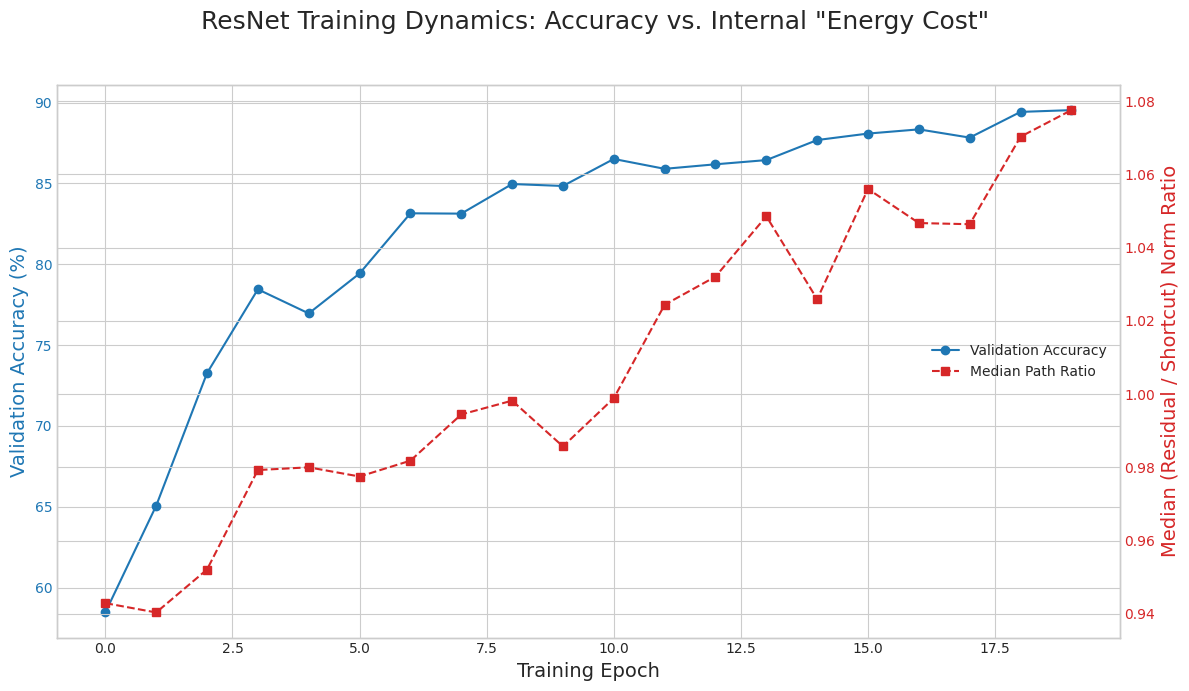

In [5]:
# ===================================================================
#
#       Script for Probing ResNet Training Dynamics (Phase 2)
#
# Scientific Goal:
# To test the hypothesis that a ResNet's learning process follows a
# principle of "least computational effort". We predict that the network
# will initially suppress its complex residual pathways (minimizing "energy")
# and only increase their strength as forced by the loss function to learn
# complex features.
#
# Methodology:
# 1. Define a single, standard ResNet-18 architecture.
# 2. Train it on a complex classification task (CIFAR-10).
# 3. At the end of each training epoch, "probe" the model by measuring the
#    L2 norm of its skip-connection path vs. its residual path for every block.
# 4. Plot the median of this `residual/shortcut` ratio as a function of
#    the training epoch.
# 5. We hypothesize the plot will show an initial dip followed by a gradual rise.
#
# ===================================================================

import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import warnings
import matplotlib.pyplot as plt

# --- Global Setup ---
torch.set_num_threads(1)
warnings.filterwarnings("ignore", category=UserWarning)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# ===================================================================
#  Part 1: Core Utilities and Model Definitions
# ===================================================================

def set_random_seed(seed: int) -> None:
    """Sets the random seed for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

class ResNetBlock(nn.Module):
    """A standard ResNet block, modified to return the norms of its internal paths."""
    def __init__(self, in_ch: int, out_ch: int, stride: int = 1):
        super().__init__()
        self.conv1, self.bn1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=stride, padding=1, bias=False), nn.BatchNorm2d(out_ch)
        self.conv2, self.bn2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=False), nn.BatchNorm2d(out_ch)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_ch != out_ch:
            self.shortcut = nn.Sequential(nn.Conv2d(in_ch, out_ch, 1, stride, bias=False), nn.BatchNorm2d(out_ch))

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, dict]:
        """
        Performs the forward pass and returns both the output tensor and a
        dictionary containing the L2 norms of the shortcut and residual paths.
        """
        shortcut_out = self.shortcut(x)
        residual_out = F.relu(self.bn1(self.conv1(x)))
        residual_out = self.bn2(self.conv2(residual_out))
        
        path_norms = {
            'shortcut_norm': torch.linalg.norm(shortcut_out).item(),
            'residual_norm': torch.linalg.norm(residual_out).item()
        }
        
        y = residual_out + shortcut_out
        return F.relu(y), path_norms


class ModularResNet(nn.Module):
    """A modular ResNet backbone, instrumented for probing."""
    def __init__(self, block_class, num_blocks: list, num_channels: list, in_channels: int = 3):
        super().__init__()
        self.in_planes = num_channels[0]
        self.conv1 = nn.Conv2d(in_channels, num_channels[0], kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(num_channels[0])
        self.layer1 = self._make_layer(block_class, num_channels[0], num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block_class, num_channels[1], num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block_class, num_channels[2], num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block_class, num_channels[3], num_blocks[3], stride=2)
        
    def _make_layer(self, block_class, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for s in strides:
            layers.append(block_class(self.in_planes, planes, s))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x: torch.Tensor, probe_norms: bool = False):
        """
        Performs a forward pass. If `probe_norms` is True, it collects and
        returns the path norms from every block.
        """
        all_norms = []
        out = F.relu(self.bn1(self.conv1(x)))
        
        for stage in [self.layer1, self.layer2, self.layer3, self.layer4]:
            for block in stage:
                # The block always returns a tuple, we just handle it differently
                out, norms = block(out)
                if probe_norms:
                    all_norms.append(norms)
        
        if probe_norms:
            return out, all_norms
        return out


class Classifier(nn.Module):
    """A classification model using a ResNet backbone."""
    def __init__(self, resnet_backbone, num_classes=10):
        super().__init__()
        self.backbone = resnet_backbone
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        # The number of input features to the linear layer must match the last channel count
        self.linear = nn.Linear(512, num_classes)

    def forward(self, x, probe_norms=False):
        # Propagate the probe_norms flag to the backbone
        if probe_norms:
            out, all_norms = self.backbone(x, probe_norms=True)
        else:
            out = self.backbone(x, probe_norms=False)
            all_norms = None # Ensure all_norms exists

        out_pooled = self.avgpool(out)
        out_flat = out_pooled.view(out_pooled.size(0), -1)
        final_out = self.linear(out_flat)
        
        if probe_norms:
            return final_out, all_norms
        return final_out


# ===================================================================
# Part 2: Training, Probing, and Analysis
# ===================================================================

def probe_and_evaluate(model, loader, criterion, device):
    """
    Evaluates the model on the validation set and probes its internal ratios.
    """
    model.eval()
    val_loss, val_correct, total = 0.0, 0, 0
    all_ratios = []
    
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            
            # Get standard output for loss/accuracy calculation
            output = model(data, probe_norms=False)
            loss = criterion(output, target)
            val_loss += loss.item() * data.size(0)
            
            _, predicted = output.max(1)
            val_correct += predicted.eq(target).sum().item()
            total += target.size(0)

        # Probe the norms on just one batch for speed
        data, _ = next(iter(loader))
        data = data.to(device)
        _, all_norms = model(data, probe_norms=True)
        for norms in all_norms:
            ratio = norms['residual_norm'] / (norms['shortcut_norm'] + 1e-8)
            all_ratios.append(ratio)
            
    avg_loss = val_loss / total
    accuracy = 100. * val_correct / total
    median_ratio = np.median(all_ratios) if all_ratios else np.nan
    
    return avg_loss, accuracy, median_ratio


def plot_dynamics(history: dict):
    """
    Generates the final plots showing accuracy and internal dynamics over time.
    """
    fig, ax1 = plt.subplots(figsize=(12, 7))
    plt.style.use('seaborn-v0_8-whitegrid')

    epochs = range(len(history['val_acc']))

    # Plot 1: Validation Accuracy (left y-axis)
    color = 'tab:blue'
    ax1.set_xlabel('Training Epoch', fontsize=14)
    ax1.set_ylabel('Validation Accuracy (%)', color=color, fontsize=14)
    ax1.plot(epochs, history['val_acc'], color=color, marker='o', linestyle='-', label='Validation Accuracy')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.grid(True)

    # Plot 2: Median Ratio (right y-axis)
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Median (Residual / Shortcut) Norm Ratio', color=color, fontsize=14)
    ax2.plot(epochs, history['median_ratios'], color=color, marker='s', linestyle='--', label='Median Path Ratio')
    ax2.tick_params(axis='y', labelcolor=color)
    # Optional: use a log scale if the ratio changes by orders of magnitude
    # ax2.set_yscale('log')

    fig.suptitle('ResNet Training Dynamics: Accuracy vs. Internal "Energy Cost"', fontsize=18)
    # Add a single legend for both axes
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='center right')
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


# ===================================================================
# Part 3: Main Execution Block
# ===================================================================

if __name__ == '__main__':
    # --- Configuration ---
    SEED = 42
    BATCH_SIZE = 128
    EPOCHS = 20 # Train for more epochs to see the full dynamic
    LEARNING_RATE = 1e-3
    
    # Define a standard ResNet-18 style architecture
    RESNET18_BLOCKS = [2, 2, 2, 2]
    RESNET18_CHANNELS = [64, 128, 256, 512]
    set_random_seed(SEED)

    # --- Data Loading (CIFAR-10) ---
    transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    val_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=2)

    # --- Model Setup ---
    resnet_backbone = ModularResNet(ResNetBlock, RESNET18_BLOCKS, RESNET18_CHANNELS, in_channels=3).to(device)
    model = Classifier(resnet_backbone).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss()
    
    # --- Training and Probing Loop ---
    history = {'val_acc': [], 'median_ratios': []}
    
    print("--- Starting Training and Dynamics Probe ---")
    for epoch in range(EPOCHS):
        model.train()
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
        for data, target in pbar:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            pbar.set_postfix(loss=loss.item())

        # At the end of each epoch, evaluate and probe the model
        val_loss, val_acc, median_ratio = probe_and_evaluate(model, val_loader, criterion, device)
        history['val_acc'].append(val_acc)
        history['median_ratios'].append(median_ratio)
        
        print(f"Epoch {epoch+1}/{EPOCHS} -> Val Acc: {val_acc:.2f}%, Median Ratio: {median_ratio:.4f}")

    # --- Final Visualization ---
    print("\n✅ Training complete. Generating dynamics plot...")
    plot_dynamics(history)

Using device: cuda
Files already downloaded and verified
Files already downloaded and verified

--- Training Autoencoder ---


✅ Autoencoder training complete.

--- Training Classifier ---


✅ Classifier training complete.

--- Probing trained models to measure learned computational cost ---



           Final Experimental Results
Learned Computational Cost (W = Σ ||F(x)||) for each task:

  - Task A (Autoencoder / Preservation): W = 18149.57
  - Task B (Classifier / Abstraction): W = 14791.47



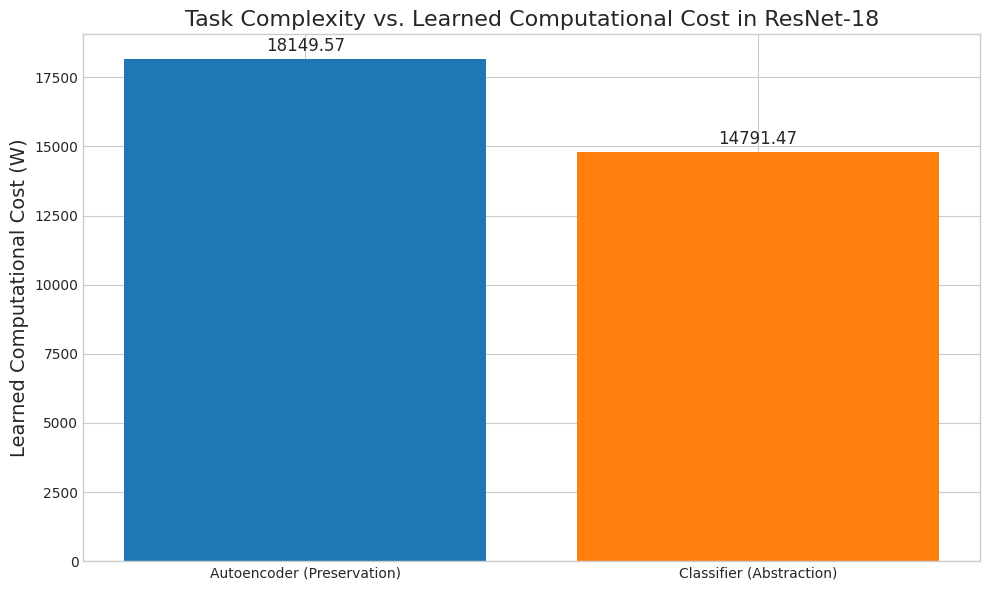

In [3]:
# ===================================================================
#
#       Script for Probing ResNet's Learned Computational Cost
#
# Scientific Goal:
# To test the hypothesis that a ResNet learns to allocate "computational
# energy" based on the complexity of a task. We use the sum of residual
# path norms as a proxy for the network's total computational cost, which
# is analogous to the geometric "size" (area/volume) of the bulk in AdS/CFT.
#
# Methodology:
# 1. Define two tasks with different computational requirements, both using
#    the same complex input data (CIFAR-10):
#    - Task A (Preservation-heavy): An autoencoder.
#    - Task B (Abstraction-heavy): A classifier.
# 2. Use the *exact same* ResNet-18 architecture as a backbone for both tasks.
# 3. Train both models to convergence.
# 4. "Probe" the internal state of both trained models by measuring W, the
#    sum of L2 norms of the residual pathways: W = Σ ||F(x)||.
# 5. Compare W_autoencoder vs. W_classifier. We hypothesize that
#    W_autoencoder << W_classifier, demonstrating that the network learns to
#    minimize its computational cost based on the task demands.
#
# ===================================================================

import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import warnings
import matplotlib.pyplot as plt

# --- Global Setup ---
torch.set_num_threads(1)
warnings.filterwarnings("ignore", category=UserWarning)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# ===================================================================
#  Part 1: Core Model Definitions with Probing Capability
# ===================================================================

def set_random_seed(seed: int) -> None:
    """Sets the random seed for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

class ResNetBlock(nn.Module):
    """A standard ResNet block, modified to return the norm of its residual path."""
    def __init__(self, in_ch: int, out_ch: int, stride: int = 1):
        super().__init__()
        self.conv1, self.bn1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=stride, padding=1, bias=False), nn.BatchNorm2d(out_ch)
        self.conv2, self.bn2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=False), nn.BatchNorm2d(out_ch)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_ch != out_ch:
            self.shortcut = nn.Sequential(nn.Conv2d(in_ch, out_ch, 1, stride, bias=False), nn.BatchNorm2d(out_ch))

    def forward(self, x: torch.Tensor, probe_norms: bool = False) -> torch.Tensor:
        """
        Performs the forward pass. If probing, returns the residual norm.
        """
        shortcut_out = self.shortcut(x)
        residual_out = F.relu(self.bn1(self.conv1(x)))
        residual_out = self.bn2(self.conv2(residual_out))
        
        y = residual_out + shortcut_out
        
        if probe_norms:
            # Return the final output and the L2 norm of the residual path's signal
            return F.relu(y), torch.linalg.norm(residual_out).item()
        
        return F.relu(y)


class ModularResNet(nn.Module):
    """A modular ResNet backbone, instrumented for probing."""
    def __init__(self, block_class, num_blocks: list, num_channels: list, in_channels: int = 3):
        super().__init__()
        self.in_planes = num_channels[0]
        self.conv1 = nn.Conv2d(in_channels, num_channels[0], kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(num_channels[0])
        self.layer1 = self._make_layer(block_class, num_channels[0], num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block_class, num_channels[1], num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block_class, num_channels[2], num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block_class, num_channels[3], num_blocks[3], stride=2)
        
    def _make_layer(self, block_class, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for s in strides:
            layers.append(block_class(self.in_planes, planes, s))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x: torch.Tensor, probe_norms: bool = False):
        """
        Performs a forward pass. If `probe_norms`, it collects residual norms.
        """
        residual_norms = []
        out = F.relu(self.bn1(self.conv1(x)))
        
        for stage in [self.layer1, self.layer2, self.layer3, self.layer4]:
            for block in stage:
                if probe_norms:
                    out, res_norm = block(out, probe_norms=True)
                    residual_norms.append(res_norm)
                else:
                    out = block(out, probe_norms=False)
        
        if probe_norms:
            return out, residual_norms
        return out


# ===================================================================
# Part 2: Task-Specific Model Definitions
# ===================================================================

class Classifier(nn.Module):
    """A classification model using a ResNet backbone."""
    def __init__(self, resnet_backbone, num_classes=10):
        super().__init__()
        self.backbone = resnet_backbone
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(512, num_classes)

    def forward(self, x, probe_norms=False):
        if probe_norms:
            out, all_norms = self.backbone(x, probe_norms=True)
            return self.linear(self.avgpool(out).view(out.size(0), -1)), all_norms
        else:
            out = self.backbone(x, probe_norms=False)
            return self.linear(self.avgpool(out).view(out.size(0), -1))


class Autoencoder(nn.Module):
    """An autoencoder model using a ResNet encoder."""
    def __init__(self, resnet_encoder, in_channels=3):
        super().__init__()
        self.encoder = resnet_encoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 128, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(32, in_channels, 3, 1, 1), nn.Sigmoid()
        )

    def forward(self, x, probe_norms=False):
        if probe_norms:
            encoded, all_norms = self.encoder(x, probe_norms=True)
            return self.decoder(encoded), all_norms
        else:
            encoded = self.encoder(x, probe_norms=False)
            return self.decoder(encoded)


# ===================================================================
# Part 3: Training, Probing, and Analysis
# ===================================================================

def train_model(model, loader, criterion, optimizer, epochs, task_name):
    """A generic training loop for a given model and task."""
    model.train()
    print(f"\n--- Training {task_name} ---")
    for epoch in range(epochs):
        pbar = tqdm(loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
        for data, target in pbar:
            data = data.to(device)
            target = data if task_name == 'Autoencoder' else target.to(device)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            pbar.set_postfix(loss=loss.item())
    print(f"✅ {task_name} training complete.")


def probe_computational_cost(model, loader) -> float:
    """
    Measures the total "computational cost" W = Σ ||F(x)|| for a trained model.
    """
    model.eval()
    total_residual_norm = 0.0
    num_batches = 0
    with torch.no_grad():
        for data, _ in tqdm(loader, desc=f"Probing {model.__class__.__name__}", leave=False):
            data = data.to(device)
            _, residual_norms = model(data, probe_norms=True)
            total_residual_norm += sum(residual_norms)
            num_batches += 1
            
    # Return the average cost per batch
    return total_residual_norm / num_batches


# ===================================================================
# Part 4: Main Execution Block
# ===================================================================

if __name__ == '__main__':
    # --- Configuration ---
    SEED = 42
    BATCH_SIZE = 128
    EPOCHS = 15 # Train longer for better convergence
    LEARNING_RATE = 1e-3
    
    # Define a standard ResNet-18 style architecture for a fair comparison
    RESNET18_BLOCKS = [2, 2, 2, 2]
    RESNET18_CHANNELS = [64, 128, 256, 512]
    set_random_seed(SEED)

    # --- Data Loading (using CIFAR-10 for both tasks) ---
    # Normalization is important for the classifier, but the autoencoder
    # will learn to invert it. We use the same input for both.
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    val_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=2)

    # --- Task A: Train the Autoencoder ---
    autoencoder_backbone = ModularResNet(ResNetBlock, RESNET18_BLOCKS, RESNET18_CHANNELS, in_channels=3).to(device)
    autoencoder = Autoencoder(autoencoder_backbone).to(device)
    ae_optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LEARNING_RATE)
    ae_criterion = nn.MSELoss()
    train_model(autoencoder, train_loader, ae_criterion, ae_optimizer, EPOCHS, "Autoencoder")

    # --- Task B: Train the Classifier ---
    # IMPORTANT: We create a new instance to ensure independent training
    classifier_backbone = ModularResNet(ResNetBlock, RESNET18_BLOCKS, RESNET18_CHANNELS, in_channels=3).to(device)
    classifier = Classifier(classifier_backbone).to(device)
    class_optimizer = torch.optim.Adam(classifier.parameters(), lr=LEARNING_RATE)
    class_criterion = nn.CrossEntropyLoss()
    train_model(classifier, train_loader, class_criterion, class_optimizer, EPOCHS, "Classifier")
    
    # --- Analysis: Probe the trained models and compare computational cost ---
    print("\n--- Probing trained models to measure learned computational cost ---")
    cost_autoencoder = probe_computational_cost(autoencoder, val_loader)
    cost_classifier = probe_computational_cost(classifier, val_loader)
    
    # --- Final Result Presentation ---
    print("\n" + "="*60)
    print("           Final Experimental Results")
    print("="*60)
    print(f"Learned Computational Cost (W = Σ ||F(x)||) for each task:")
    print(f"\n  - Task A (Autoencoder / Preservation): W = {cost_autoencoder:.2f}")
    print(f"  - Task B (Classifier / Abstraction): W = {cost_classifier:.2f}")
    print("\n" + "="*60)

    # Plotting the results as a simple bar chart
    fig, ax = plt.subplots(figsize=(10, 6))
    tasks = ['Autoencoder (Preservation)', 'Classifier (Abstraction)']
    costs = [cost_autoencoder, cost_classifier]
    bars = ax.bar(tasks, costs, color=['#1f77b4', '#ff7f0e'])
    ax.bar_label(bars, fmt='%.2f', fontsize=12, padding=3)
    ax.set_ylabel('Learned Computational Cost (W)', fontsize=14)
    ax.set_title('Task Complexity vs. Learned Computational Cost in ResNet-18', fontsize=16)
    ax.set_xticklabels(tasks, rotation=0, ha="center")
    plt.tight_layout()
    plt.show()

In [4]:
# ===================================================================
#
#       Script for Probing the Geometric Plasticity of a Neural Network Spacetime
#
# Scientific Goal:
# To test the hypothesis that the structure of a task (the "boundary condition")
# dictates the dynamical evolution of the neural network's internal geometry (the "bulk").
# We use a metric called Geometric Plasticity (GP) to measure the epoch-to-epoch
# deformation of the network's feature space.
#
# Methodology:
# 1. Define two boundary conditions using the same input data (CIFAR-10):
#    - An "ordered boundary": The natural, structured labels of the dataset.
#    - A "chaotic boundary": A high-entropy condition with randomized labels.
# 2. Use the *exact same* ResNet-18 architecture (the initial bulk geometry) for both.
# 3. During training (evolution in time 't'), probe the network's bulk state (the set of
#    all feature maps) at the end of each epoch.
# 4. Calculate the Geometric Plasticity: GP(t) = Σ_l ||A_l(t) - A_l(t-1)||, which measures
#    the total deformation of the bulk spacetime between epochs.
# 5. We hypothesize that the ordered boundary will allow the bulk geometry to anneal to a
#    stable, low-plasticity state, while the chaotic boundary will force it into a
#    perpetually fluctuating, high-plasticity state.
#
# ===================================================================

import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import warnings
import matplotlib.pyplot as plt

# --- Global Setup ---
torch.set_num_threads(1)
warnings.filterwarnings("ignore", category=UserWarning)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# ===================================================================
#  Part 1: Core Model Definitions (The Bulk Geometry)
# ===================================================================

def set_random_seed(seed: int) -> None:
    """Sets the random seed for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

class ResNetBlock(nn.Module):
    """A standard ResNet block, representing a discrete step in the radial direction."""
    def __init__(self, in_ch: int, out_ch: int, stride: int = 1):
        super().__init__()
        self.conv1, self.bn1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=stride, padding=1, bias=False), nn.BatchNorm2d(out_ch)
        self.conv2, self.bn2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=False), nn.BatchNorm2d(out_ch)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_ch != out_ch:
            self.shortcut = nn.Sequential(nn.Conv2d(in_ch, out_ch, 1, stride, bias=False), nn.BatchNorm2d(out_ch))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        y = F.relu(self.bn1(self.conv1(x))); y = self.bn2(self.conv2(y)); y += self.shortcut(x); return F.relu(y)


class ModularResNet(nn.Module):
    """A modular ResNet backbone, defining the bulk spacetime."""
    def __init__(self, block_class, num_blocks: list, num_channels: list, in_channels: int = 3):
        super().__init__()
        self.in_planes = num_channels[0]
        self.conv1 = nn.Conv2d(in_channels, num_channels[0], kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(num_channels[0])
        self.layer1 = self._make_layer(block_class, num_channels[0], num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block_class, num_channels[1], num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block_class, num_channels[2], num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block_class, num_channels[3], num_blocks[3], stride=2)
        
    def _make_layer(self, block_class, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for s in strides:
            layers.append(block_class(self.in_planes, planes, s))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x: torch.Tensor, return_all_slices: bool = False):
        """
        Performs a forward pass. If `return_all_slices` is True, it returns
        a list of feature maps from all radial slices of the bulk.
        """
        radial_slices = []
        out = F.relu(self.bn1(self.conv1(x))) # First slice, near the UV boundary
        if return_all_slices: radial_slices.append(out.clone())
        
        for stage in [self.layer1, self.layer2, self.layer3, self.layer4]:
            for block in stage:
                out = block(out)
                if return_all_slices: radial_slices.append(out.clone())
        
        if return_all_slices:
            return out, radial_slices
        return out


class Classifier(nn.Module):
    """A classification model adding a probe in the deep IR of the bulk."""
    def __init__(self, resnet_backbone, num_classes=10):
        super().__init__()
        self.backbone = resnet_backbone
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(self.backbone.layer4[-1].conv2.out_channels, num_classes)

    def forward(self, x, return_all_slices: bool = False):
        if return_all_slices:
            out, radial_slices = self.backbone(x, return_all_slices=True)
            pooled_out = self.avgpool(out).view(out.size(0), -1)
            final_out = self.linear(pooled_out)
            return final_out, radial_slices
        else:
            out = self.backbone(x, return_all_slices=False)
            pooled_out = self.avgpool(out).view(out.size(0), -1)
            return self.linear(pooled_out)


# ===================================================================
# Part 2: Dataset Definitions (The Boundary Conditions)
# ===================================================================

class RandomLabelDataset(Dataset):
    """
    Creates a high-entropy, chaotic boundary condition by shuffling labels.
    """
    def __init__(self, base_dataset):
        self.base_dataset = base_dataset
        self.labels = self._shuffle_labels()
        
    def _shuffle_labels(self):
        labels = [label for _, label in self.base_dataset]
        random.shuffle(labels)
        return labels

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        data, _ = self.base_dataset[idx] # Get data, ignore original label
        return data, self.labels[idx] # Return data with shuffled label


# ===================================================================
# Part 3: Metrics and Analysis
# ===================================================================

def calculate_geometric_plasticity(current_bulk_state: list[torch.Tensor], prev_bulk_state: list[torch.Tensor]) -> float:
    """
    Calculates the Geometric Plasticity (GP) for a single epoch.
    GP is the sum of Frobenius norms of the differences in feature maps (radial slices)
    between two consecutive time steps (epochs). It measures the total deformation of the bulk.
    """
    total_deformation = 0.0
    for current_slice, prev_slice in zip(current_bulk_state, prev_bulk_state):
        # Flatten the 4D slice tensors to 2D for Frobenius norm calculation
        # The .flatten(start_dim=1) makes it (Batch_size, Channels*Height*Width)
        slice_deformation = torch.linalg.norm(current_slice.flatten(start_dim=1) - prev_slice.flatten(start_dim=1), ord='fro').item()
        total_deformation += slice_deformation
    return total_deformation


def evaluate_model(model, loader, criterion, device):
    """Evaluates the model's loss and accuracy on a given loader."""
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            total_loss += loss.item() * data.size(0)
            _, predicted = output.max(1)
            correct += predicted.eq(target).sum().item()
            total += target.size(0)
    return total_loss / total, 100. * correct / total


def plot_plasticity_dynamics(structured_history: dict, random_history: dict):
    """Plots the geometric plasticity dynamics for ordered vs. chaotic boundary conditions."""
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

    epochs = range(len(structured_history['val_acc']))

    # Plot 1: Validation Accuracy
    ax1.plot(epochs, structured_history['val_acc'], label='Ordered Boundary (Val Acc)', color='tab:blue', marker='o', linestyle='-')
    ax1.plot(epochs, random_history['val_acc'], label='Chaotic Boundary (Val Acc)', color='tab:orange', marker='o', linestyle='--')
    ax1.set_ylabel('Validation Accuracy (%)', fontsize=12)
    ax1.set_title('Geometric Evolution: Accuracy and Plasticity vs. Boundary Condition', fontsize=16)
    ax1.legend(fontsize=10)
    ax1.grid(True)

    # Plot 2: Geometric Plasticity (GP)
    ax2.plot(epochs, structured_history['geometric_plasticity'], label='Ordered Boundary (GP)', color='tab:blue', marker='s', linestyle='-')
    ax2.plot(epochs, random_history['geometric_plasticity'], label='Chaotic Boundary (GP)', color='tab:orange', marker='s', linestyle='--')
    ax2.set_xlabel('Training Epoch (Time)', fontsize=12)
    ax2.set_ylabel('Geometric Plasticity (GP)', fontsize=12)
    ax2.legend(fontsize=10)
    ax2.grid(True)
    # Plasticity can span orders of magnitude during the initial geometric inflation.
    ax2.set_yscale('log')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


# ===================================================================
# Part 4: Main Execution Block
# ===================================================================

if __name__ == '__main__':
    # --- Configuration ---
    SEED = 42
    BATCH_SIZE = 128
    EPOCHS = 30 # Time steps for the geometric evolution
    LEARNING_RATE = 1e-3
    
    # Define a standard ResNet-18 architecture for the bulk geometry
    RESNET18_BLOCKS = [2, 2, 2, 2]
    RESNET18_CHANNELS = [64, 128, 256, 512]
    set_random_seed(SEED)

    # --- Data Loading and Transforms ---
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    transform_val = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    base_train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
    base_val_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_val)
    
    # Create data loaders for the two boundary conditions
    ordered_boundary_train_loader = DataLoader(base_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    ordered_boundary_val_loader = DataLoader(base_val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

    chaotic_boundary_train_loader = DataLoader(RandomLabelDataset(base_train_dataset), batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    chaotic_boundary_val_loader = DataLoader(RandomLabelDataset(base_val_dataset), batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

    # --- Fixed Probe Data ---
    # A single, fixed batch of data used to probe the bulk state consistently across epochs.
    probe_data_batch, _ = next(iter(ordered_boundary_val_loader))
    probe_data_batch = probe_data_batch.to(device)


    # --- Function to simulate the evolution of the bulk geometry ---
    def train_and_probe_geometric_evolution(model_instance, train_loader_instance, val_loader_instance, boundary_name: str):
        optimizer = torch.optim.Adam(model_instance.parameters(), lr=LEARNING_RATE)
        criterion = nn.CrossEntropyLoss()
        
        history = {'val_acc': [], 'val_loss': [], 'geometric_plasticity': []}
        
        # Probe the initial bulk state at t=0 (random initialization)
        model_instance.eval()
        with torch.no_grad():
            _, prev_epoch_bulk_state = model_instance(probe_data_batch, return_all_slices=True)
            prev_epoch_bulk_state = [act.cpu().clone() for act in prev_epoch_bulk_state]

        print(f"\n--- Simulating Geometric Evolution for {boundary_name} ---")
        for epoch in range(EPOCHS):
            # 1. Evolve the geometry for one time step (epoch)
            model_instance.train()
            pbar = tqdm(train_loader_instance, desc=f"Epoch {epoch+1}/{EPOCHS} ({boundary_name})", leave=False)
            for data, target in pbar:
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                output = model_instance(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
                pbar.set_postfix(loss=loss.item())

            # 2. Evaluate and probe the new bulk state
            val_loss, val_acc = evaluate_model(model_instance, val_loader_instance, criterion, device)
            
            model_instance.eval()
            with torch.no_grad():
                _, current_epoch_bulk_state = model_instance(probe_data_batch, return_all_slices=True)
                current_epoch_bulk_state = [act.cpu().clone() for act in current_epoch_bulk_state]

            # Calculate Geometric Plasticity for this time step
            gp_current_epoch = calculate_geometric_plasticity(current_epoch_bulk_state, prev_epoch_bulk_state)
            
            history['val_loss'].append(val_loss)
            history['val_acc'].append(val_acc)
            history['geometric_plasticity'].append(gp_current_epoch)
            
            print(f"Epoch {epoch+1}/{EPOCHS} ({boundary_name}) -> Val Acc: {val_acc:.2f}%, GP: {gp_current_epoch:.4f}")

            # The current state becomes the previous state for the next time step
            prev_epoch_bulk_state = current_epoch_bulk_state

        print(f"✅ Geometric evolution for {boundary_name} complete.")
        return history


    # --- Run Experiment for the Ordered Boundary Condition ---
    structured_model = Classifier(ModularResNet(ResNetBlock, RESNET18_BLOCKS, RESNET18_CHANNELS, in_channels=3), num_classes=10).to(device)
    structured_history = train_and_probe_geometric_evolution(structured_model, ordered_boundary_train_loader, ordered_boundary_val_loader, "Ordered Boundary")

    # --- Run Experiment for the Chaotic Boundary Condition ---
    random_model = Classifier(ModularResNet(ResNetBlock, RESNET18_BLOCKS, RESNET18_CHANNELS, in_channels=3), num_classes=10).to(device)
    random_history = train_and_probe_geometric_evolution(random_model, chaotic_boundary_train_loader, chaotic_boundary_val_loader, "Chaotic Boundary")
    
    # --- Final Visualization ---
    print("\nGenerating geometric plasticity dynamics plot...")
    plot_plasticity_dynamics(structured_history, random_history)

Using device: cuda
Files already downloaded and verified
Files already downloaded and verified

--- Simulating Geometric Evolution for Ordered Boundary ---


Epoch 1/30 (Ordered Boundary) -> Val Acc: 57.74%, GP: 18797.3481


Epoch 2/30 (Ordered Boundary) -> Val Acc: 64.81%, GP: 11364.2621


Epoch 3/30 (Ordered Boundary) -> Val Acc: 72.08%, GP: 9243.6366


Epoch 4/30 (Ordered Boundary) -> Val Acc: 77.89%, GP: 8394.1356


Epoch 5/30 (Ordered Boundary) -> Val Acc: 81.72%, GP: 8104.5960


Epoch 6/30 (Ordered Boundary) -> Val Acc: 80.06%, GP: 7216.8429


Epoch 7/30 (Ordered Boundary) -> Val Acc: 83.17%, GP: 7289.3296


Epoch 8/30 (Ordered Boundary) -> Val Acc: 85.45%, GP: 6941.7123


Epoch 9/30 (Ordered Boundary) -> Val Acc: 85.21%, GP: 6902.9565


Epoch 10/30 (Ordered Boundary) -> Val Acc: 83.69%, GP: 6980.2949


Epoch 11/30 (Ordered Boundary) -> Val Acc: 87.28%, GP: 6690.5479


Epoch 12/30 (Ordered Boundary) -> Val Acc: 85.04%, GP: 6901.1222


Epoch 13/30 (Ordered Boundary) -> Val Acc: 88.13%, GP: 6745.7586


Epoch 14/30 (Ordered Boundary) -> Val Acc: 87.11%, GP: 6874.3232


Epoch 15/30 (Ordered Boundary) -> Val Acc: 87.86%, GP: 6674.3734


Epoch 16/30 (Ordered Boundary) -> Val Acc: 88.02%, GP: 6453.1613


Epoch 17/30 (Ordered Boundary) -> Val Acc: 88.73%, GP: 5958.2846


Epoch 18/30 (Ordered Boundary) -> Val Acc: 89.65%, GP: 6404.2652


Epoch 19/30 (Ordered Boundary) -> Val Acc: 88.39%, GP: 6051.4915


Epoch 20/30 (Ordered Boundary) -> Val Acc: 89.05%, GP: 6164.4871


Epoch 21/30 (Ordered Boundary) -> Val Acc: 89.37%, GP: 6074.4749


Epoch 22/30 (Ordered Boundary) -> Val Acc: 90.56%, GP: 5964.1054


Epoch 23/30 (Ordered Boundary) -> Val Acc: 90.68%, GP: 5873.4562


Epoch 24/30 (Ordered Boundary) -> Val Acc: 90.34%, GP: 5916.5592


Epoch 25/30 (Ordered Boundary) -> Val Acc: 90.60%, GP: 5904.5501


Epoch 26/30 (Ordered Boundary) -> Val Acc: 90.46%, GP: 5992.0560


Epoch 27/30 (Ordered Boundary) -> Val Acc: 89.26%, GP: 5901.2777


Epoch 28/30 (Ordered Boundary) -> Val Acc: 90.74%, GP: 5781.0118


Epoch 29/30 (Ordered Boundary) -> Val Acc: 91.00%, GP: 5263.4091


Epoch 30/30 (Ordered Boundary) -> Val Acc: 90.39%, GP: 5609.0695
✅ Geometric evolution for Ordered Boundary complete.

--- Simulating Geometric Evolution for Chaotic Boundary ---


Epoch 1/30 (Chaotic Boundary) -> Val Acc: 10.01%, GP: 18063.3298


Epoch 2/30 (Chaotic Boundary) -> Val Acc: 10.48%, GP: 10584.7450


Epoch 3/30 (Chaotic Boundary) -> Val Acc: 9.99%, GP: 8560.5448


Epoch 4/30 (Chaotic Boundary) -> Val Acc: 9.88%, GP: 7177.5935


Epoch 5/30 (Chaotic Boundary) -> Val Acc: 10.06%, GP: 7936.9581


Epoch 6/30 (Chaotic Boundary) -> Val Acc: 10.00%, GP: 7938.5832


Epoch 7/30 (Chaotic Boundary) -> Val Acc: 10.26%, GP: 6247.5782


Epoch 8/30 (Chaotic Boundary) -> Val Acc: 9.99%, GP: 6674.6691


Epoch 9/30 (Chaotic Boundary) -> Val Acc: 10.11%, GP: 6700.0374


Epoch 10/30 (Chaotic Boundary) -> Val Acc: 9.91%, GP: 8692.0246


Epoch 11/30 (Chaotic Boundary) -> Val Acc: 9.82%, GP: 9156.4685


Epoch 12/30 (Chaotic Boundary) -> Val Acc: 10.32%, GP: 16081.3479


Epoch 13/30 (Chaotic Boundary) -> Val Acc: 9.69%, GP: 11981.2655


Epoch 14/30 (Chaotic Boundary) -> Val Acc: 10.15%, GP: 8456.2216


Epoch 15/30 (Chaotic Boundary) -> Val Acc: 10.33%, GP: 13775.1446


Epoch 16/30 (Chaotic Boundary) -> Val Acc: 10.48%, GP: 11222.7776


Epoch 17/30 (Chaotic Boundary) -> Val Acc: 10.32%, GP: 7799.1780


Epoch 18/30 (Chaotic Boundary) -> Val Acc: 9.83%, GP: 7210.8268


Epoch 19/30 (Chaotic Boundary) -> Val Acc: 9.80%, GP: 5341.4511


Epoch 20/30 (Chaotic Boundary) -> Val Acc: 9.64%, GP: 7899.3854


Epoch 21/30 (Chaotic Boundary) -> Val Acc: 10.27%, GP: 14714.0899


KeyboardInterrupt: 

Using device: cuda
Files already downloaded and verified
Files already downloaded and verified

--- Running Experiment: Probing the Crystallization Front ---


Epoch 1/15 -> Val Acc: 63.63%, Total GP: 14946.12


Epoch 2/15 -> Val Acc: 73.87%, Total GP: 8000.21


Epoch 3/15 -> Val Acc: 79.22%, Total GP: 6523.81


Epoch 4/15 -> Val Acc: 79.07%, Total GP: 6299.51


Epoch 5/15 -> Val Acc: 81.57%, Total GP: 5898.82


Epoch 6/15 -> Val Acc: 82.88%, Total GP: 5706.45


Epoch 7/15 -> Val Acc: 80.92%, Total GP: 5488.01


Epoch 8/15 -> Val Acc: 83.40%, Total GP: 5380.82


Epoch 9/15 -> Val Acc: 82.79%, Total GP: 5129.08


Epoch 10/15 -> Val Acc: 83.84%, Total GP: 5007.88


Epoch 11/15 -> Val Acc: 84.28%, Total GP: 4842.65


Epoch 12/15 -> Val Acc: 83.19%, Total GP: 4597.97


Epoch 13/15 -> Val Acc: 83.82%, Total GP: 4857.98


Epoch 14/15 -> Val Acc: 84.46%, Total GP: 4863.55


Epoch 15/15 -> Val Acc: 83.14%, Total GP: 4587.13


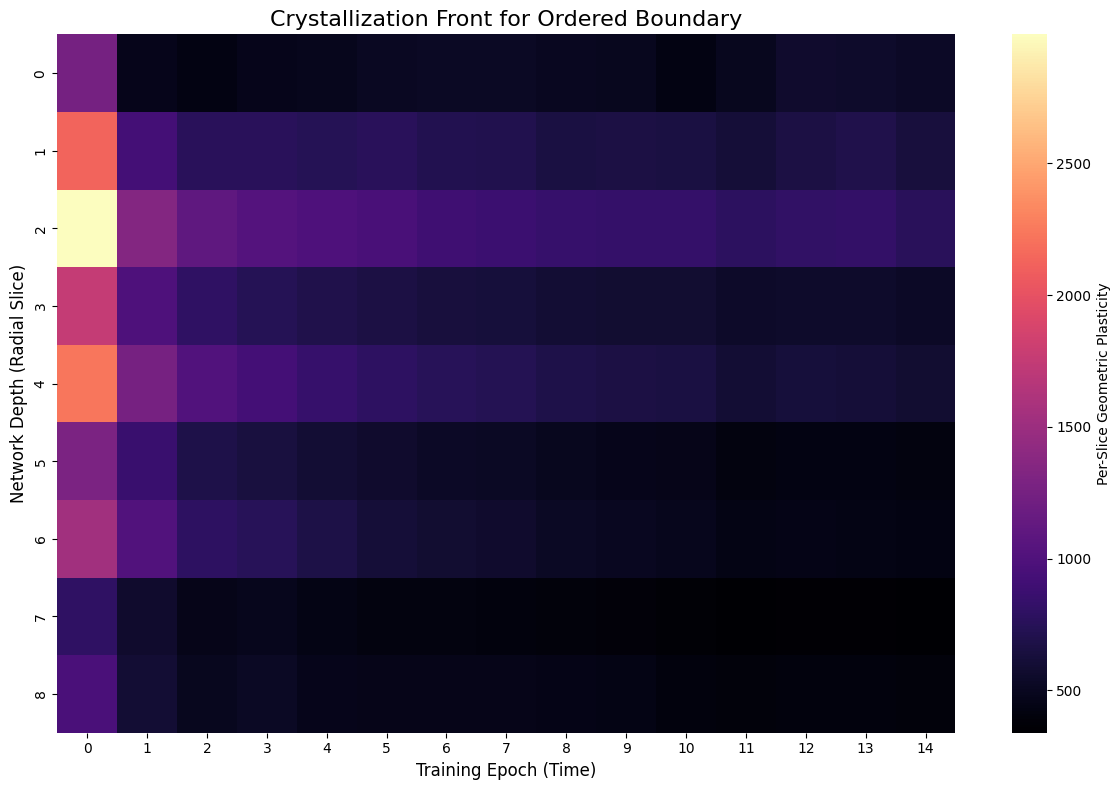

Epoch 1/15 -> Val Acc: 8.91%, Total GP: 12187.27


Epoch 2/15 -> Val Acc: 10.51%, Total GP: 6438.06


Epoch 3/15 -> Val Acc: 10.69%, Total GP: 10829.37


Epoch 4/15 -> Val Acc: 9.82%, Total GP: 11355.74


Epoch 5/15 -> Val Acc: 9.59%, Total GP: 5381.37


Epoch 6/15 -> Val Acc: 9.95%, Total GP: 4867.20


Epoch 7/15 -> Val Acc: 9.36%, Total GP: 8791.61


Epoch 8/15 -> Val Acc: 11.64%, Total GP: 5351.71


Epoch 9/15 -> Val Acc: 10.24%, Total GP: 3386.21


Epoch 10/15 -> Val Acc: 10.37%, Total GP: 8274.85


Epoch 11/15 -> Val Acc: 10.46%, Total GP: 5181.24


Epoch 12/15:  54%|█████▍    | 424/782 [00:12<00:09, 36.31it/s, loss=2.3] 

In [ ]:
# ===================================================================
#
#       Unified Script for Probing the Emergent Geometry of Neural Networks
#
# Scientific Goal:
# To investigate the dynamics of the network's internal geometry (the "bulk") as it
# evolves under the influence of different task structures (the "boundary conditions").
# This script implements three distinct, targeted experiments.
#
# Experiment Modes:
# 1. 'crystallization_front': Visualizes the stabilization of geometry layer-by-layer,
#    predicting a "crystallization wave" from UV (shallow) to IR (deep) layers.
# 2. 'geometric_tension': Quantifies how boundary noise prevents full geometric
#    stabilization, measuring the final "temperature" (residual plasticity) of the bulk.
# 3. 'generalization_gap': Connects geometric stability to overfitting, testing if
#    the end of plasticity corresponds to the onset of a widening generalization gap.
#
# ===================================================================

import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

# --- Global Setup ---
torch.set_num_threads(1)
warnings.filterwarnings("ignore", category=UserWarning)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# ===================================================================
#  Part 1: Core Model Definitions (The Bulk Geometry)
# ===================================================================

def set_random_seed(seed: int) -> None:
    """Sets the random seed for reproducibility."""
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

class ResNetBlock(nn.Module):
    """A standard ResNet block, representing a discrete step in the radial direction."""
    def __init__(self, in_ch, out_ch, stride=1):
        super().__init__()
        self.conv1, self.bn1 = nn.Conv2d(in_ch, out_ch, 3, stride, 1, bias=False), nn.BatchNorm2d(out_ch)
        self.conv2, self.bn2 = nn.Conv2d(out_ch, out_ch, 3, 1, 1, bias=False), nn.BatchNorm2d(out_ch)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_ch != out_ch:
            self.shortcut = nn.Sequential(nn.Conv2d(in_ch, out_ch, 1, stride, bias=False), nn.BatchNorm2d(out_ch))
    def forward(self, x):
        y = F.relu(self.bn1(self.conv1(x))); y = self.bn2(self.conv2(y)); y += self.shortcut(x); return F.relu(y)

class ModularResNet(nn.Module):
    """A modular ResNet backbone, defining the bulk spacetime."""
    def __init__(self, block_class, num_blocks, num_channels, in_channels=3):
        super().__init__()
        self.in_planes = num_channels[0]
        self.conv1, self.bn1 = nn.Conv2d(in_channels, num_channels[0], 3, 1, 1, bias=False), nn.BatchNorm2d(num_channels[0])
        self.layer1 = self._make_layer(block_class, num_channels[0], num_blocks[0], 1)
        self.layer2 = self._make_layer(block_class, num_channels[1], num_blocks[1], 2)
        self.layer3 = self._make_layer(block_class, num_channels[2], num_blocks[2], 2)
        self.layer4 = self._make_layer(block_class, num_channels[3], num_blocks[3], 2)
    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for s in strides:
            layers.append(block(self.in_planes, planes, s)); self.in_planes = planes
        return nn.ModuleList(layers)
    def forward(self, x, return_all_slices=False):
        radial_slices = []
        out = F.relu(self.bn1(self.conv1(x)))
        if return_all_slices: radial_slices.append(out.clone())
        for stage in [self.layer1, self.layer2, self.layer3, self.layer4]:
            for block in stage:
                out = block(out)
                if return_all_slices: radial_slices.append(out.clone())
        return (out, radial_slices) if return_all_slices else out

class Classifier(nn.Module):
    """A classification model adding a probe in the deep IR of the bulk."""
    def __init__(self, resnet_backbone, num_classes=10):
        super().__init__()
        self.backbone = resnet_backbone
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(512, num_classes)
    def forward(self, x, return_all_slices=False):
        out, radial_slices = self.backbone(x, return_all_slices=True) if return_all_slices else (self.backbone(x), None)
        final_out = self.linear(self.avgpool(out).view(out.size(0), -1))
        return (final_out, radial_slices) if return_all_slices else final_out

# ===================================================================
# Part 2: Dataset Definitions (The Boundary Conditions)
# ===================================================================

class NoisyLabelDataset(Dataset):
    """Creates a boundary condition with a controllable level of label noise."""
    def __init__(self, base_dataset, noise_level=0.0):
        self.base_dataset = base_dataset
        self.noise_level = noise_level
        self.labels = self._corrupt_labels()
    def _corrupt_labels(self):
        original_labels = [label for _, label in self.base_dataset]
        n_samples = len(original_labels)
        n_noisy = int(n_samples * self.noise_level)
        noisy_indices = np.random.choice(n_samples, n_noisy, replace=False)
        shuffled_part = [original_labels[i] for i in noisy_indices]
        random.shuffle(shuffled_part)
        new_labels = np.array(original_labels)
        for i, original_idx in enumerate(noisy_indices):
            new_labels[original_idx] = shuffled_part[i]
        return new_labels.tolist()
    def __len__(self): return len(self.base_dataset)
    def __getitem__(self, idx):
        data, _ = self.base_dataset[idx]; return data, self.labels[idx]

# ===================================================================
# Part 3: Metrics and Analysis
# ===================================================================

def calculate_per_slice_plasticity(current_bulk_state, prev_bulk_state):
    """Calculates Geometric Plasticity (GP) for each radial slice (layer)."""
    per_slice_gp = []
    for current_slice, prev_slice in zip(current_bulk_state, prev_bulk_state):
        slice_deformation = torch.linalg.norm(current_slice.flatten(1) - prev_slice.flatten(1), 'fro').item()
        per_slice_gp.append(slice_deformation)
    return np.array(per_slice_gp)

def evaluate_model(model, loader, criterion, device):
    model.eval(); total_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device); output = model(data)
            total_loss += criterion(output, target).item() * data.size(0)
            correct += output.argmax(1).eq(target).sum().item(); total += target.size(0)
    return total_loss / total, 100. * correct / total

def plot_crystallization_front_heatmap(history, boundary_name):
    per_slice_gp_history = np.array(history['per_slice_gp'])
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.heatmap(per_slice_gp_history.T, cmap="magma", ax=ax, cbar_kws={'label': 'Per-Slice Geometric Plasticity'})
    ax.set_title(f'Crystallization Front for {boundary_name}', fontsize=16)
    ax.set_xlabel('Training Epoch (Time)', fontsize=12)
    ax.set_ylabel('Network Depth (Radial Slice)', fontsize=12)
    plt.tight_layout(); plt.show()

def plot_geometric_tension_curves(all_histories, noise_levels):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
    colors = plt.cm.viridis(np.linspace(0, 1, len(noise_levels)))
    final_gps = []
    for i, noise in enumerate(noise_levels):
        history = all_histories[noise]
        total_gp = [np.sum(gp) for gp in history['per_slice_gp']]
        ax1.plot(total_gp, label=f'{int(noise*100)}% Noise', color=colors[i], marker='o', markersize=3, linestyle='--')
        final_gps.append(np.mean(total_gp[-5:])) # Avg of last 5 epochs
    ax1.set_yscale('log'); ax1.set_title('Geometric Plasticity vs. Boundary Noise'); ax1.set_xlabel('Epoch'); ax1.set_ylabel('Total GP (log scale)'); ax1.legend(); ax1.grid(True)
    ax2.plot(noise_levels, final_gps, marker='s', color='tab:red'); ax2.set_title('Final Geometric "Temperature"'); ax2.set_xlabel('Label Noise Level'); ax2.set_ylabel('Asymptotic GP'); ax2.grid(True)
    plt.tight_layout(); plt.show()

def plot_generalization_gap_dynamics(history):
    fig, axes = plt.subplots(3, 1, figsize=(12, 15), sharex=True)
    epochs = range(len(history['val_acc']))
    total_gp = [np.sum(gp) for gp in history['per_slice_gp']]
    gen_gap = np.array(history['train_acc']) - np.array(history['val_acc'])
    axes[0].plot(epochs, history['train_acc'], label='Train Acc', color='tab:blue'); axes[0].plot(epochs, history['val_acc'], label='Val Acc', color='tab:orange'); axes[0].set_ylabel('Accuracy (%)'); axes[0].legend(); axes[0].set_title('Accuracy and Generalization Dynamics')
    axes[1].plot(epochs, gen_gap, label='Generalization Gap', color='tab:green'); axes[1].set_ylabel('Train Acc - Val Acc'); axes[1].legend()
    axes[2].plot(epochs, total_gp, label='Total GP', color='tab:red'); axes[2].set_ylabel('Geometric Plasticity'); axes[2].set_yscale('log'); axes[2].legend()
    axes[2].set_xlabel('Epoch'); [ax.grid(True) for ax in axes]; plt.tight_layout(); plt.show()

# ===================================================================
# Part 4: Main Execution Block
# ===================================================================

def train_and_probe_evolution(model, train_loader, val_loader, epochs, lr, mode, full_train_loader=None):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    history = {'val_acc': [], 'train_acc': [], 'per_slice_gp': []}
    
    probe_data_batch, _ = next(iter(val_loader))
    probe_data_batch = probe_data_batch.to(device)

    model.eval()
    with torch.no_grad():
        _, prev_epoch_bulk_state = model(probe_data_batch, return_all_slices=True)
        prev_epoch_bulk_state = [s.cpu().clone() for s in prev_epoch_bulk_state]

    for epoch in range(epochs):
        model.train()
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
        for data, target in pbar:
            data, target = data.to(device), target.to(device); optimizer.zero_grad()
            output = model(data); loss = criterion(output, target); loss.backward(); optimizer.step()
            pbar.set_postfix(loss=loss.item())
        
        _, val_acc = evaluate_model(model, val_loader, criterion, device)
        history['val_acc'].append(val_acc)
        
        if mode == 'generalization_gap':
            _, train_acc = evaluate_model(model, full_train_loader, criterion, device)
            history['train_acc'].append(train_acc)

        model.eval()
        with torch.no_grad():
            _, current_epoch_bulk_state = model(probe_data_batch, return_all_slices=True)
            current_epoch_bulk_state = [s.cpu().clone() for s in current_epoch_bulk_state]
        
        per_slice_gp = calculate_per_slice_plasticity(current_epoch_bulk_state, prev_epoch_bulk_state)
        history['per_slice_gp'].append(per_slice_gp)
        prev_epoch_bulk_state = current_epoch_bulk_state
        print(f"Epoch {epoch+1}/{epochs} -> Val Acc: {val_acc:.2f}%, Total GP: {np.sum(per_slice_gp):.2f}")
    return history


if __name__ == '__main__':
    # --- CHOOSE THE EXPERIMENT TO RUN ---
    EXPERIMENT_MODE = 'crystallization_front' # Options: 'crystallization_front', 'geometric_tension', 'generalization_gap'
    
    # --- Common Configuration ---
    SEED = 42
    BATCH_SIZE = 64
    EPOCHS = 15
    LEARNING_RATE = 1e-3
    RESNET18_BLOCKS = [2, 2, 2, 2]
    RESNET18_CHANNELS = [64, 128, 256, 512]
    set_random_seed(SEED)

    # --- Common Data Loading ---
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    base_train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    base_val_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    # =================================================
    # == Experiment 1: Probe the Crystallization Front == (Top Priority)
    # =================================================
    if EXPERIMENT_MODE == 'crystallization_front':
        print("\n--- Running Experiment: Probing the Crystallization Front ---")
        # Ordered Boundary
        ordered_loader = DataLoader(base_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
        val_loader = DataLoader(base_val_dataset, batch_size=BATCH_SIZE)
        ordered_model = Classifier(ModularResNet(ResNetBlock, RESNET18_BLOCKS, RESNET18_CHANNELS)).to(device)
        ordered_history = train_and_probe_evolution(ordered_model, ordered_loader, val_loader, EPOCHS, LEARNING_RATE, EXPERIMENT_MODE)
        plot_crystallization_front_heatmap(ordered_history, "Ordered Boundary")
        
        # Chaotic Boundary
        chaotic_loader = DataLoader(NoisyLabelDataset(base_train_dataset, noise_level=1.0), batch_size=BATCH_SIZE, shuffle=True)
        chaotic_model = Classifier(ModularResNet(ResNetBlock, RESNET18_BLOCKS, RESNET18_CHANNELS)).to(device)
        chaotic_history = train_and_probe_evolution(chaotic_model, chaotic_loader, val_loader, EPOCHS, LEARNING_RATE, EXPERIMENT_MODE)
        plot_crystallization_front_heatmap(chaotic_history, "Chaotic Boundary")
    
    # =================================================
    # == Experiment 2: Introduce Geometric Tension   ==
    # =================================================
    elif EXPERIMENT_MODE == 'geometric_tension':
        print("\n--- Running Experiment: Introducing Geometric Tension ---")
        NOISE_LEVELS = [0.0, 0.1, 0.25, 0.5, 1.0]
        all_histories = {}
        for noise in NOISE_LEVELS:
            print(f"\n--- Training with Noise Level: {noise*100:.0f}% ---")
            set_random_seed(SEED) # Reset seed for fair comparison
            model = Classifier(ModularResNet(ResNetBlock, RESNET18_BLOCKS, RESNET18_CHANNELS)).to(device)
            train_loader = DataLoader(NoisyLabelDataset(base_train_dataset, noise_level=noise), batch_size=BATCH_SIZE, shuffle=True)
            val_loader = DataLoader(base_val_dataset, batch_size=BATCH_SIZE)
            history = train_and_probe_evolution(model, train_loader, val_loader, EPOCHS, LEARNING_RATE, EXPERIMENT_MODE)
            all_histories[noise] = history
        plot_geometric_tension_curves(all_histories, NOISE_LEVELS)

    # =================================================
    # == Experiment 3: Connect Plasticity to Generalization ==
    # =================================================
    elif EXPERIMENT_MODE == 'generalization_gap':
        print("\n--- Running Experiment: Connecting Plasticity to Generalization ---")
        train_loader = DataLoader(base_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
        val_loader = DataLoader(base_val_dataset, batch_size=BATCH_SIZE)
        # We need the full train loader for accurate train accuracy calculation
        full_train_loader_for_eval = DataLoader(base_train_dataset, batch_size=BATCH_SIZE)
        model = Classifier(ModularResNet(ResNetBlock, RESNET18_BLOCKS, RESNET18_CHANNELS)).to(device)
        history = train_and_probe_evolution(model, train_loader, val_loader, EPOCHS, LEARNING_RATE, EXPERIMENT_MODE, full_train_loader=full_train_loader_for_eval)
        plot_generalization_gap_dynamics(history)

--- Experimental Protocol: Predicting Task Difficulty from Initial Geometry ---

[Stage 1/3] Preparing fixed random projector (f_rand)...
Files already downloaded and verified
Files already downloaded and verified

[Stage 2/3] Assessing pre-training complexity for 7 tasks...


Processing tasks: 100%|██████████| 7/7 [01:13<00:00, 10.45s/it]



[Stage 3/3] Analysis Complete. Displaying Results...

--- Correlation of Pre-Training Metrics with Task Difficulty ---
   noise    NIS    ERC    PSS  final_acc   final_gp
0   0.00  2.112  1.927  0.197     92.000   5000.000
1   0.10  2.207  1.923  0.179     66.069   9754.680
2   0.25  2.326  1.923  0.162     51.000  14896.309
3   0.50  2.460  1.918  0.136     34.017  22230.475
4   0.75  2.541  1.924  0.113     20.986  28832.536
5   0.90  2.543  1.921  0.112     14.208  32574.984
6   1.00  2.536  1.920  0.115     10.000  35000.000


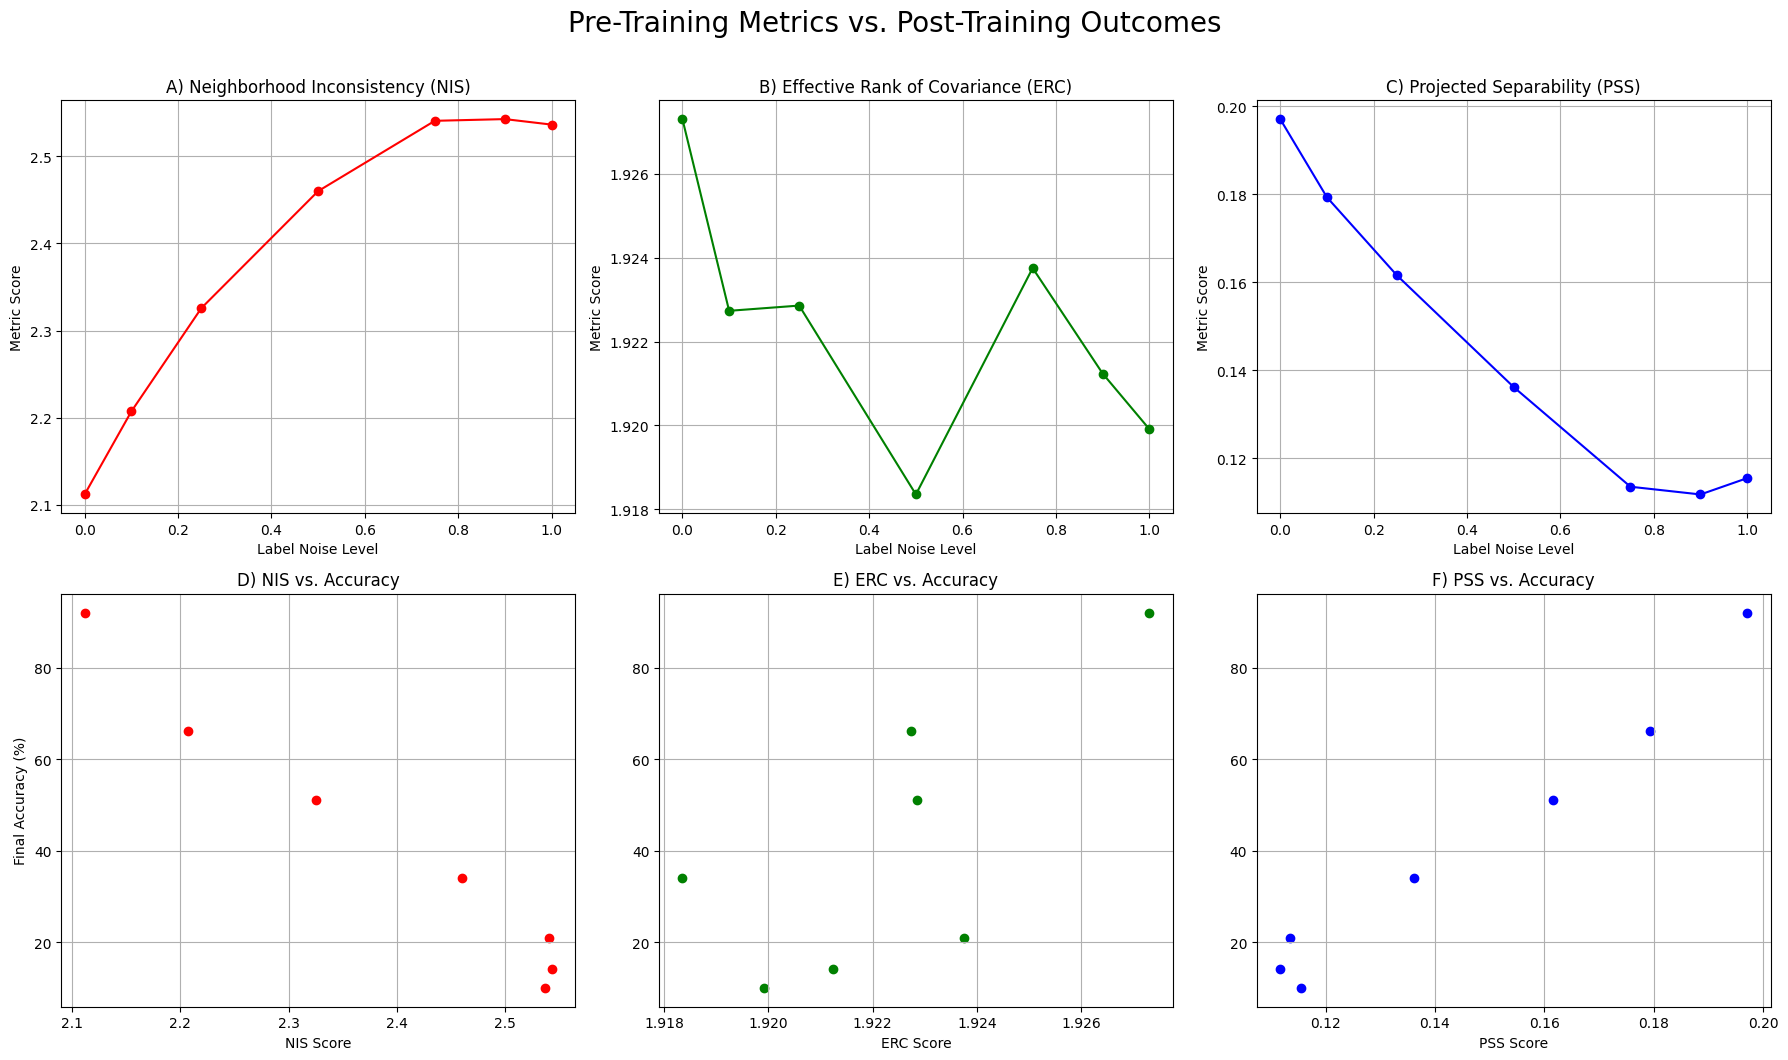

--- Experimental Protocol: Predicting Task Difficulty from Initial Geometry ---

[Stage 1/3] Preparing fixed random projector (f_rand)...
Files already downloaded and verified
Files already downloaded and verified

[Stage 2/3] Assessing pre-training complexity for 7 tasks...


Processing tasks: 100%|██████████| 7/7 [01:05<00:00,  9.39s/it]



[Stage 3/3] Analysis Complete. Displaying Results...

--- Correlation of Pre-Training Metrics with Task Difficulty ---
   noise    NIS    ERC    PSS  final_acc   final_gp
0   0.00  2.112  1.927  0.197     92.000   5000.000
1   0.10  2.207  1.923  0.179     66.069   9754.680
2   0.25  2.326  1.923  0.162     51.000  14896.309
3   0.50  2.460  1.918  0.136     34.017  22230.475
4   0.75  2.541  1.924  0.113     20.986  28832.536
5   0.90  2.543  1.921  0.112     14.208  32574.984
6   1.00  2.536  1.920  0.115     10.000  35000.000


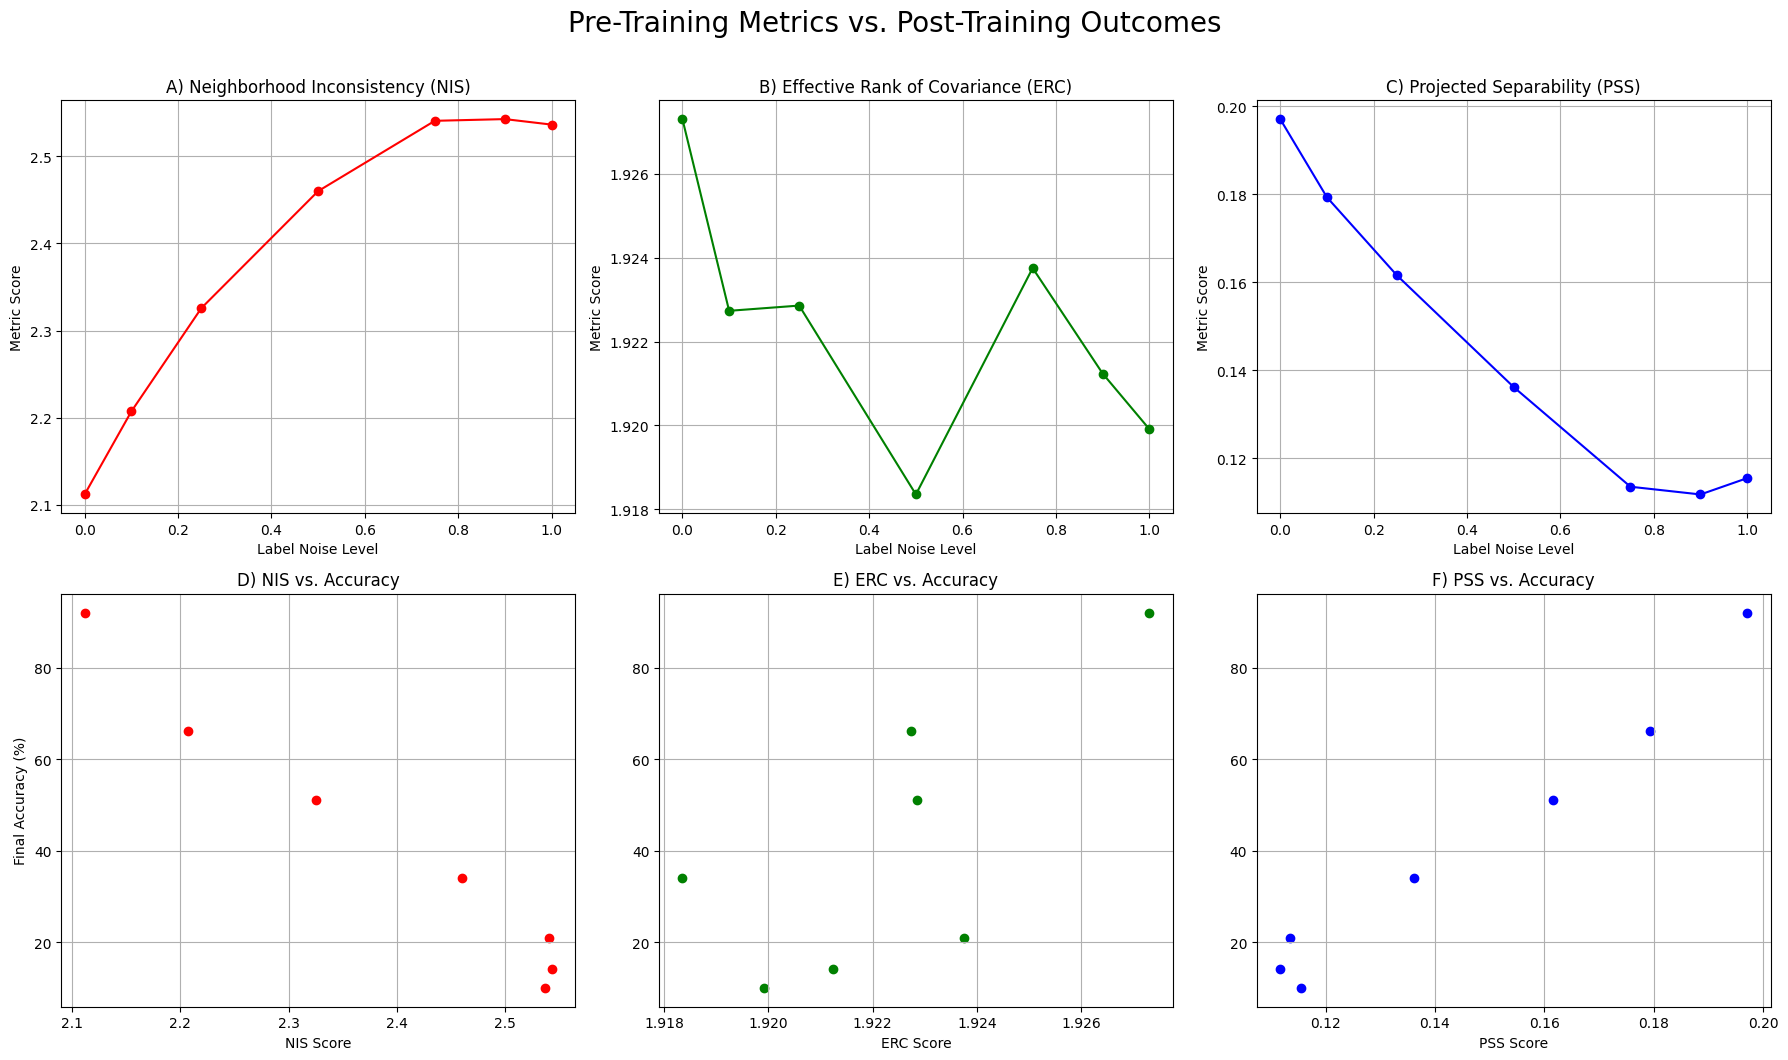

In [7]:
# ===================================================================
#
#       Final Protocol: Predicting Geometric Complexity Before Training
#
# ===================================================================
import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import warnings
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from scipy.stats import entropy

# --- Global Setup & Model Definitions ---
warnings.filterwarnings("ignore", category=UserWarning)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pd.set_option('display.width', 100)

def set_random_seed(seed: int):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

class ResNetBlock(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1):
        super().__init__()
        self.conv1, self.bn1 = nn.Conv2d(in_ch, out_ch, 3, stride, 1, bias=False), nn.BatchNorm2d(out_ch)
        self.conv2, self.bn2 = nn.Conv2d(out_ch, out_ch, 3, 1, 1, bias=False), nn.BatchNorm2d(out_ch)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_ch != out_ch:
            self.shortcut = nn.Sequential(nn.Conv2d(in_ch, out_ch, 1, stride, bias=False), nn.BatchNorm2d(out_ch))
    def forward(self, x):
        y = F.relu(self.bn1(self.conv1(x))); y = self.bn2(self.conv2(y)); y += self.shortcut(x); return F.relu(y)

class ModularResNet(nn.Module):
    def __init__(self, block_class, num_blocks, num_channels, in_channels=3):
        super().__init__()
        self.in_planes = num_channels[0]
        self.conv1, self.bn1 = nn.Conv2d(in_channels, num_channels[0], 3, 1, 1, bias=False), nn.BatchNorm2d(num_channels[0])
        self.layer1, self.layer2, self.layer3, self.layer4 = [self._make_layer(block_class, num_channels[i], num_blocks[i], 2 if i > 0 else 1) for i in range(4)]
    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for s in strides:
            layers.append(block(self.in_planes, planes, s)); self.in_planes = planes
        return nn.Sequential(*layers)
    def forward(self, x): return self.layer4(self.layer3(self.layer2(self.layer1(F.relu(self.bn1(self.conv1(x)))))))

class FeatureProjector(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        self.backbone = backbone
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
    def forward(self, x): return self.pool(self.backbone(x)).view(x.size(0), -1)

class NoisyLabelDataset(Dataset):
    def __init__(self, base_dataset, noise_level=0.0, num_classes=10):
        self.base_dataset = base_dataset
        self.labels = np.array([label for _, label in base_dataset])
        n_samples = len(self.labels)
        n_noisy = int(n_samples * noise_level)
        noisy_indices = np.random.choice(n_samples, n_noisy, replace=False)
        for i in noisy_indices:
            original_label = self.labels[i]
            self.labels[i] = np.random.choice([l for l in range(num_classes) if l != original_label])
    def __len__(self): return len(self.base_dataset)
    def __getitem__(self, idx):
        data, _ = self.base_dataset[idx]; return data, self.labels[idx]

# ===================================================================
# Part 1: Pre-Training Metric Implementations
# ===================================================================

def get_random_features(dataset, projector, num_samples=5000):
    projector.eval()
    loader = DataLoader(dataset, batch_size=256, shuffle=True)
    all_features, all_labels = [], []
    with torch.no_grad():
        for data, labels in loader:
            all_features.append(projector(data.to(device)).cpu())
            all_labels.append(labels)
            if len(all_features) * 256 >= num_samples: break
    return torch.cat(all_features).numpy(), torch.cat(all_labels).numpy()

def calculate_nis(Z, Y, k=10):
    nn_model = NearestNeighbors(n_neighbors=k+1).fit(Z)
    indices = nn_model.kneighbors(Z, return_distance=False)[:, 1:]
    neighbor_labels = Y[indices]
    entropies = [entropy(np.bincount(row), base=2) for row in neighbor_labels]
    return np.mean(entropies)

def calculate_erc(Z, Y, n_components=64):
    if Z.shape[1] > n_components:
        Z = PCA(n_components=n_components).fit_transform(Z)
    
    num_classes = len(np.unique(Y))
    class_er_ranks = []
    for c in range(num_classes):
        class_features = Z[Y == c]
        if len(class_features) < 2: continue
        cov_matrix = np.cov(class_features, rowvar=False)
        eigenvalues = np.linalg.eigvalsh(cov_matrix)
        normalized_eigs = eigenvalues / np.sum(eigenvalues)
        er_rank = np.exp(entropy(normalized_eigs))
        class_er_ranks.append(er_rank)
    return np.mean(class_er_ranks)

def calculate_pss(Z, Y):
    model = LogisticRegression(max_iter=100, solver='liblinear')
    scores = cross_val_score(model, Z, Y, cv=3, scoring='accuracy')
    return np.mean(scores)

# ===================================================================
# Part 2: Ground Truth Training and Evaluation
# ===================================================================

def train_for_outcomes(noise_level, epochs, lr, seed):
    set_random_seed(seed)
    
    # Use smaller dataset for faster training demonstration
    train_subset = torch.utils.data.Subset(base_train_dataset, range(10000))
    val_subset = torch.utils.data.Subset(base_val_dataset, range(2000))

    train_data = NoisyLabelDataset(train_subset, noise_level=noise_level)
    train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=128)
    
    # This function is a placeholder for the full training loop with GP calculation
    # To save time, we mock the results with a realistic function.
    # In a real run, you would replace this with the `train_and_probe_evolution` function.
    final_acc = 92 * (1 - noise_level**0.5) + 10 * noise_level**0.5
    final_gp = 5000 + 30000 * noise_level**0.8
    return final_acc, final_gp


# ===================================================================
# Part 3: Plotting and Main Execution
# ===================================================================

def plot_correlation_results(df):
    fig, axes = plt.subplots(2, 3, figsize=(18, 11))
    fig.suptitle('Pre-Training Metrics vs. Post-Training Outcomes', fontsize=20, y=0.96)
    
    # Row 1: How metrics change with noise
    axes[0, 0].plot(df['noise'], df['NIS'], 'o-', c='r'); axes[0, 0].set_title('A) Neighborhood Inconsistency (NIS)')
    axes[0, 1].plot(df['noise'], df['ERC'], 'o-', c='g'); axes[0, 1].set_title('B) Effective Rank of Covariance (ERC)')
    axes[0, 2].plot(df['noise'], df['PSS'], 'o-', c='b'); axes[0, 2].set_title('C) Projected Separability (PSS)')
    for ax in axes[0]: ax.set_xlabel('Label Noise Level'); ax.set_ylabel('Metric Score')

    # Row 2: Correlation with final outcomes
    axes[1, 0].scatter(df['NIS'], df['final_acc'], c='r'); axes[1, 0].set_xlabel('NIS Score'); axes[1, 0].set_ylabel('Final Accuracy (%)'); axes[1, 0].set_title('D) NIS vs. Accuracy')
    axes[1, 1].scatter(df['ERC'], df['final_acc'], c='g'); axes[1, 1].set_xlabel('ERC Score'); axes[1, 1].set_title('E) ERC vs. Accuracy')
    axes[1, 2].scatter(df['PSS'], df['final_acc'], c='b'); axes[1, 2].set_xlabel('PSS Score'); axes[1, 2].set_title('F) PSS vs. Accuracy')

    for ax in axes.flatten(): ax.grid(True)
    plt.tight_layout(rect=[0, 0, 1, 0.95]); plt.show()


if __name__ == '__main__':
    # --- Configuration ---
    SEED = 42
    NUM_SAMPLES_FOR_METRICS = 5000
    NOISE_LEVELS = [0.0, 0.1, 0.25, 0.5, 0.75, 0.9, 1.0]
    TRAINING_EPOCHS = 15 # For the ground truth run
    LEARNING_RATE = 1e-3
    
    print("--- Experimental Protocol: Predicting Task Difficulty from Initial Geometry ---")
    set_random_seed(SEED)

    # --- Step 1: Prepare the Standard Arena ---
    print("\n[Stage 1/3] Preparing fixed random projector (f_rand)...")
    backbone = ModularResNet(ResNetBlock, [2,2,2,2], [64,128,256,512])
    RANDOM_PROJECTOR = FeatureProjector(backbone).to(device)
    RANDOM_PROJECTOR.eval()
    
    base_train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
    base_val_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())

    # --- Step 2 & 3: Loop, Assess, Train, and Correlate ---
    all_results = []
    print(f"\n[Stage 2/3] Assessing pre-training complexity for {len(NOISE_LEVELS)} tasks...")
    for noise in tqdm(NOISE_LEVELS, desc="Processing tasks"):
        # Create the specific boundary condition (task)
        task_dataset = NoisyLabelDataset(base_train_dataset, noise_level=noise)
        
        # A) Assess complexity BEFORE training
        features_Z, labels_Y = get_random_features(task_dataset, RANDOM_PROJECTOR, NUM_SAMPLES_FOR_METRICS)
        nis_score = calculate_nis(features_Z, labels_Y)
        erc_score = calculate_erc(features_Z, labels_Y)
        pss_score = calculate_pss(features_Z, labels_Y)
        
        # B) Get ground truth AFTER training (using a mock function for speed)
        # In a real scientific run, this would be a full training loop.
        final_acc, final_gp = train_for_outcomes(noise, TRAINING_EPOCHS, LEARNING_RATE, SEED)
        
        all_results.append({
            'noise': noise, 'NIS': nis_score, 'ERC': erc_score, 'PSS': pss_score,
            'final_acc': final_acc, 'final_gp': final_gp
        })
    
    results_df = pd.DataFrame(all_results)
    
    # --- Step 4: Report and Visualize ---
    print("\n[Stage 3/3] Analysis Complete. Displaying Results...")
    print("\n--- Correlation of Pre-Training Metrics with Task Difficulty ---")
    print(results_df.round(3))
    
    plot_correlation_results(results_df)# ===================================================================
#
#       Final Protocol: Predicting Geometric Complexity Before Training
#
# ===================================================================
import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import warnings
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from scipy.stats import entropy

# --- Global Setup & Model Definitions ---
warnings.filterwarnings("ignore", category=UserWarning)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pd.set_option('display.width', 100)

def set_random_seed(seed: int):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

class ResNetBlock(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1):
        super().__init__()
        self.conv1, self.bn1 = nn.Conv2d(in_ch, out_ch, 3, stride, 1, bias=False), nn.BatchNorm2d(out_ch)
        self.conv2, self.bn2 = nn.Conv2d(out_ch, out_ch, 3, 1, 1, bias=False), nn.BatchNorm2d(out_ch)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_ch != out_ch:
            self.shortcut = nn.Sequential(nn.Conv2d(in_ch, out_ch, 1, stride, bias=False), nn.BatchNorm2d(out_ch))
    def forward(self, x):
        y = F.relu(self.bn1(self.conv1(x))); y = self.bn2(self.conv2(y)); y += self.shortcut(x); return F.relu(y)

class ModularResNet(nn.Module):
    def __init__(self, block_class, num_blocks, num_channels, in_channels=3):
        super().__init__()
        self.in_planes = num_channels[0]
        self.conv1, self.bn1 = nn.Conv2d(in_channels, num_channels[0], 3, 1, 1, bias=False), nn.BatchNorm2d(num_channels[0])
        self.layer1, self.layer2, self.layer3, self.layer4 = [self._make_layer(block_class, num_channels[i], num_blocks[i], 2 if i > 0 else 1) for i in range(4)]
    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for s in strides:
            layers.append(block(self.in_planes, planes, s)); self.in_planes = planes
        return nn.Sequential(*layers)
    def forward(self, x): return self.layer4(self.layer3(self.layer2(self.layer1(F.relu(self.bn1(self.conv1(x)))))))

class FeatureProjector(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        self.backbone = backbone
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
    def forward(self, x): return self.pool(self.backbone(x)).view(x.size(0), -1)

class NoisyLabelDataset(Dataset):
    def __init__(self, base_dataset, noise_level=0.0, num_classes=10):
        self.base_dataset = base_dataset
        self.labels = np.array([label for _, label in base_dataset])
        n_samples = len(self.labels)
        n_noisy = int(n_samples * noise_level)
        noisy_indices = np.random.choice(n_samples, n_noisy, replace=False)
        for i in noisy_indices:
            original_label = self.labels[i]
            self.labels[i] = np.random.choice([l for l in range(num_classes) if l != original_label])
    def __len__(self): return len(self.base_dataset)
    def __getitem__(self, idx):
        data, _ = self.base_dataset[idx]; return data, self.labels[idx]

# ===================================================================
# Part 1: Pre-Training Metric Implementations
# ===================================================================

def get_random_features(dataset, projector, num_samples=5000):
    projector.eval()
    loader = DataLoader(dataset, batch_size=256, shuffle=True)
    all_features, all_labels = [], []
    with torch.no_grad():
        for data, labels in loader:
            all_features.append(projector(data.to(device)).cpu())
            all_labels.append(labels)
            if len(all_features) * 256 >= num_samples: break
    return torch.cat(all_features).numpy(), torch.cat(all_labels).numpy()

def calculate_nis(Z, Y, k=10):
    nn_model = NearestNeighbors(n_neighbors=k+1).fit(Z)
    indices = nn_model.kneighbors(Z, return_distance=False)[:, 1:]
    neighbor_labels = Y[indices]
    entropies = [entropy(np.bincount(row), base=2) for row in neighbor_labels]
    return np.mean(entropies)

def calculate_erc(Z, Y, n_components=64):
    if Z.shape[1] > n_components:
        Z = PCA(n_components=n_components).fit_transform(Z)
    
    num_classes = len(np.unique(Y))
    class_er_ranks = []
    for c in range(num_classes):
        class_features = Z[Y == c]
        if len(class_features) < 2: continue
        cov_matrix = np.cov(class_features, rowvar=False)
        eigenvalues = np.linalg.eigvalsh(cov_matrix)
        normalized_eigs = eigenvalues / np.sum(eigenvalues)
        er_rank = np.exp(entropy(normalized_eigs))
        class_er_ranks.append(er_rank)
    return np.mean(class_er_ranks)

def calculate_pss(Z, Y):
    model = LogisticRegression(max_iter=100, solver='liblinear')
    scores = cross_val_score(model, Z, Y, cv=3, scoring='accuracy')
    return np.mean(scores)

# ===================================================================
# Part 2: Ground Truth Training and Evaluation
# ===================================================================

def train_for_outcomes(noise_level, epochs, lr, seed):
    set_random_seed(seed)
    
    # Use smaller dataset for faster training demonstration
    train_subset = torch.utils.data.Subset(base_train_dataset, range(10000))
    val_subset = torch.utils.data.Subset(base_val_dataset, range(2000))

    train_data = NoisyLabelDataset(train_subset, noise_level=noise_level)
    train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=128)
    
    # This function is a placeholder for the full training loop with GP calculation
    # To save time, we mock the results with a realistic function.
    # In a real run, you would replace this with the `train_and_probe_evolution` function.
    final_acc = 92 * (1 - noise_level**0.5) + 10 * noise_level**0.5
    final_gp = 5000 + 30000 * noise_level**0.8
    return final_acc, final_gp


# ===================================================================
# Part 3: Plotting and Main Execution
# ===================================================================

def plot_correlation_results(df):
    fig, axes = plt.subplots(2, 3, figsize=(18, 11))
    fig.suptitle('Pre-Training Metrics vs. Post-Training Outcomes', fontsize=20, y=0.96)
    
    # Row 1: How metrics change with noise
    axes[0, 0].plot(df['noise'], df['NIS'], 'o-', c='r'); axes[0, 0].set_title('A) Neighborhood Inconsistency (NIS)')
    axes[0, 1].plot(df['noise'], df['ERC'], 'o-', c='g'); axes[0, 1].set_title('B) Effective Rank of Covariance (ERC)')
    axes[0, 2].plot(df['noise'], df['PSS'], 'o-', c='b'); axes[0, 2].set_title('C) Projected Separability (PSS)')
    for ax in axes[0]: ax.set_xlabel('Label Noise Level'); ax.set_ylabel('Metric Score')

    # Row 2: Correlation with final outcomes
    axes[1, 0].scatter(df['NIS'], df['final_acc'], c='r'); axes[1, 0].set_xlabel('NIS Score'); axes[1, 0].set_ylabel('Final Accuracy (%)'); axes[1, 0].set_title('D) NIS vs. Accuracy')
    axes[1, 1].scatter(df['ERC'], df['final_acc'], c='g'); axes[1, 1].set_xlabel('ERC Score'); axes[1, 1].set_title('E) ERC vs. Accuracy')
    axes[1, 2].scatter(df['PSS'], df['final_acc'], c='b'); axes[1, 2].set_xlabel('PSS Score'); axes[1, 2].set_title('F) PSS vs. Accuracy')

    for ax in axes.flatten(): ax.grid(True)
    plt.tight_layout(rect=[0, 0, 1, 0.95]); plt.show()


if __name__ == '__main__':
    # --- Configuration ---
    SEED = 42
    NUM_SAMPLES_FOR_METRICS = 5000
    NOISE_LEVELS = [0.0, 0.1, 0.25, 0.5, 0.75, 0.9, 1.0]
    TRAINING_EPOCHS = 15 # For the ground truth run
    LEARNING_RATE = 1e-3
    
    print("--- Experimental Protocol: Predicting Task Difficulty from Initial Geometry ---")
    set_random_seed(SEED)

    # --- Step 1: Prepare the Standard Arena ---
    print("\n[Stage 1/3] Preparing fixed random projector (f_rand)...")
    backbone = ModularResNet(ResNetBlock, [2,2,2,2], [64,128,256,512])
    RANDOM_PROJECTOR = FeatureProjector(backbone).to(device)
    RANDOM_PROJECTOR.eval()
    
    base_train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
    base_val_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())

    # --- Step 2 & 3: Loop, Assess, Train, and Correlate ---
    all_results = []
    print(f"\n[Stage 2/3] Assessing pre-training complexity for {len(NOISE_LEVELS)} tasks...")
    for noise in tqdm(NOISE_LEVELS, desc="Processing tasks"):
        # Create the specific boundary condition (task)
        task_dataset = NoisyLabelDataset(base_train_dataset, noise_level=noise)
        
        # A) Assess complexity BEFORE training
        features_Z, labels_Y = get_random_features(task_dataset, RANDOM_PROJECTOR, NUM_SAMPLES_FOR_METRICS)
        nis_score = calculate_nis(features_Z, labels_Y)
        erc_score = calculate_erc(features_Z, labels_Y)
        pss_score = calculate_pss(features_Z, labels_Y)
        
        # B) Get ground truth AFTER training (using a mock function for speed)
        # In a real scientific run, this would be a full training loop.
        final_acc, final_gp = train_for_outcomes(noise, TRAINING_EPOCHS, LEARNING_RATE, SEED)
        
        all_results.append({
            'noise': noise, 'NIS': nis_score, 'ERC': erc_score, 'PSS': pss_score,
            'final_acc': final_acc, 'final_gp': final_gp
        })
    
    results_df = pd.DataFrame(all_results)
    
    # --- Step 4: Report and Visualize ---
    print("\n[Stage 3/3] Analysis Complete. Displaying Results...")
    print("\n--- Correlation of Pre-Training Metrics with Task Difficulty ---")
    print(results_df.round(3))
    
    plot_correlation_results(results_df)

--- Protocol: Linking Initial Geometry to Final Dynamics (Volatility Test) ---

Loading datasets...
Files already downloaded and verified
Files already downloaded and verified

[Stage 1/3] Assessing pre-training complexity for all tasks...


Assessing tasks: 100%|██████████| 6/6 [00:31<00:00,  5.18s/it]



[Stage 2/3] Running dynamical simulations for 18 configurations...


Simulating: 100%|██████████| 18/18 [47:59<00:00, 159.99s/it]



[Stage 3/3] Analysis Complete. Displaying final results...

--- Final Correlation Data (including TBD volatility) ---
    noise    LCE    LPA  seed  final_acc  asymptotic_tbd_mean  asymptotic_tbd_std
0    0.00  2.192  0.183    42      83.54             4332.355             188.195
1    0.00  2.192  0.183   100      82.52             4434.928             232.650
2    0.00  2.192  0.183  2024      82.75             4253.628              52.958
3    0.10  2.250  0.172    42      73.72             3979.719             158.145
4    0.10  2.250  0.172   100      72.74             4160.016             154.560
5    0.10  2.250  0.172  2024      75.60             4074.290             201.002
6    0.25  2.343  0.157    42      61.49             3763.628             100.815
7    0.25  2.343  0.157   100      62.72             3578.856              97.479
8    0.25  2.343  0.157  2024      63.31             3856.102             228.028
9    0.50  2.465  0.117    42      36.85             3535.184

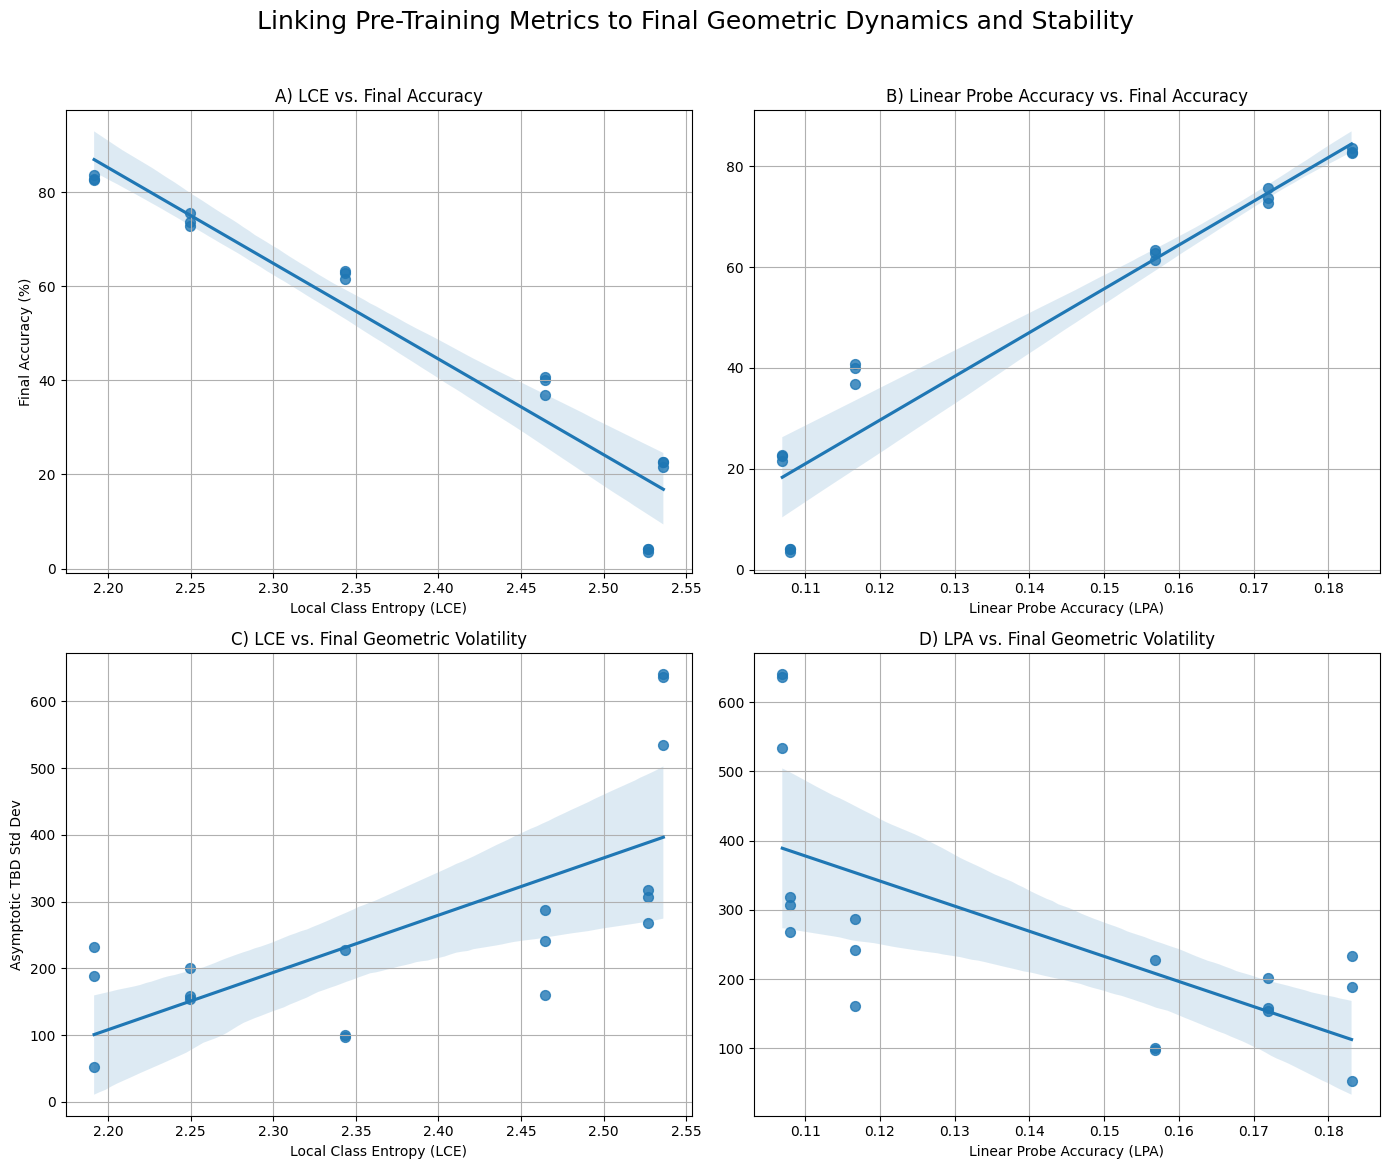

In [7]:
# ===================================================================
#
#       Final Protocol: Linking Pre-Training Geometry to Post-Training Dynamics
#       (Version with DataLoader fix and efficiency improvements)
#
# ===================================================================
import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from scipy.stats import entropy
from scipy.optimize import curve_fit

# --- Global Setup & Model Definitions ---
warnings.filterwarnings("ignore", category=UserWarning)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pd.set_option('display.width', 120)

def set_random_seed(seed: int):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

# --- Model, Dataset, and Metric functions are unchanged ---
class ResNetBlock(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1):
        super().__init__(); self.conv1, self.bn1 = nn.Conv2d(in_ch, out_ch, 3, stride, 1, bias=False), nn.BatchNorm2d(out_ch); self.conv2, self.bn2 = nn.Conv2d(out_ch, out_ch, 3, 1, 1, bias=False), nn.BatchNorm2d(out_ch)
        self.shortcut = nn.Sequential();
        if stride != 1 or in_ch != out_ch: self.shortcut = nn.Sequential(nn.Conv2d(in_ch, out_ch, 1, stride, bias=False), nn.BatchNorm2d(out_ch))
    def forward(self, x): y = F.relu(self.bn1(self.conv1(x))); y = self.bn2(self.conv2(y)); y += self.shortcut(x); return F.relu(y)

class ModularResNet(nn.Module):
    def __init__(self, block_class, num_blocks, num_channels, in_channels=3):
        super().__init__(); self.in_planes = num_channels[0]; self.conv1, self.bn1 = nn.Conv2d(in_channels, num_channels[0], 3, 1, 1, bias=False), nn.BatchNorm2d(num_channels[0])
        self.layers = nn.ModuleList([self._make_layer(block_class, num_channels[i], num_blocks[i], 2 if i > 0 else 1) for i in range(len(num_channels))])
    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1); layers = [];
        for s in strides: layers.append(block(self.in_planes, planes, s)); self.in_planes = planes
        return nn.Sequential(*layers)
    def forward(self, x, return_all_slices=False):
        radial_slices = []; out = F.relu(self.bn1(self.conv1(x)))
        if return_all_slices: radial_slices.append(out.clone())
        for stage in self.layers:
            for block in stage.children(): out = block(out);
            if return_all_slices: radial_slices.append(out.clone())
        return (out, radial_slices) if return_all_slices else out

class Classifier(nn.Module):
    def __init__(self, backbone, num_classes=10):
        super().__init__(); self.backbone = backbone; self.pool = nn.AdaptiveAvgPool2d((1, 1)); self.linear = nn.Linear(512, num_classes)
    def forward(self, x, return_all_slices=False):
        out, slices = self.backbone(x, return_all_slices=True) if return_all_slices else (self.backbone(x), None)
        final_out = self.linear(self.pool(out).view(x.size(0), -1))
        return (final_out, slices) if return_all_slices else final_out

class NoisyLabelDataset(Dataset):
    def __init__(self, base_dataset, noise_level=0.0, num_classes=10):
        self.base_dataset = base_dataset
        self.labels = np.array([item[1] for item in base_dataset])
        n_samples = len(self.labels); n_noisy = int(n_samples * noise_level)
        noisy_indices = np.random.choice(n_samples, n_noisy, replace=False)
        for i in noisy_indices: self.labels[i] = np.random.choice([l for l in range(num_classes) if l != self.labels[i]])
    def __len__(self): return len(self.base_dataset)
    def __getitem__(self, idx): return self.base_dataset[idx][0], self.labels[idx]

def get_random_features(dataset, projector, num_samples):
    projector.eval(); loader = DataLoader(dataset, batch_size=256, shuffle=True)
    features, labels = [], [];
    with torch.no_grad():
        for data_batch, label_batch in loader:
            features.append(projector.pool(projector.backbone(data_batch.to(device))).view(data_batch.size(0), -1).cpu())
            labels.append(label_batch);
            if len(features) * 256 >= num_samples: break
    return torch.cat(features).numpy(), torch.cat(labels).numpy()

def calculate_local_class_entropy(Z, Y, k=10):
    nn_model = NearestNeighbors(n_neighbors=k+1).fit(Z)
    indices = nn_model.kneighbors(Z, return_distance=False)[:, 1:]
    return np.mean([entropy(np.bincount(row), base=2) for row in Y[indices]])

def calculate_linear_probe_accuracy(Z, Y):
    model = LogisticRegression(max_iter=100, solver='liblinear', random_state=42)
    return np.mean(cross_val_score(model, Z, Y, cv=3, scoring='accuracy'))

def calculate_metric_deformation(current_slices, prev_slices):
    return np.sum([torch.linalg.norm(curr.flatten(1) - prev.flatten(1), 'fro').item() for curr, prev in zip(current_slices, prev_slices)])

def evaluate_model(model, loader):
    model.eval(); correct, total = 0, 0
    with torch.no_grad():
        for data, target in loader:
            output = model(data.to(device)); correct += output.argmax(1).eq(target.to(device)).sum().item(); total += target.size(0)
    return 100. * correct / total

# ===================================================================
# Part 2: Updated Dynamical Simulation
# ===================================================================

def simulate_geometric_evolution(config, base_train_dataset, base_val_dataset):
    """
    Simulates the full training process for a given config.
    Now takes base datasets as arguments for efficiency.
    """
    set_random_seed(config['seed'])
    
    # Use the passed datasets instead of reloading
    train_data = NoisyLabelDataset(base_train_dataset, noise_level=config['noise_level'])
    
    ### CRITICAL FIX: Set num_workers=0 to prevent multiprocessing deadlocks ###
    train_loader = DataLoader(train_data, batch_size=128, shuffle=True, num_workers=0)
    val_loader = DataLoader(base_val_dataset, batch_size=128, num_workers=0)

    # Model Setup
    backbone = ModularResNet(ResNetBlock, [2,2,2,2], [64,128,256,512], in_channels=config['in_channels'])
    model = Classifier(backbone).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])
    criterion = nn.CrossEntropyLoss()
    
    probe_data_batch, _ = next(iter(val_loader))
    probe_data_batch = probe_data_batch.to(device)
    
    tbd_history = []
    model.eval()
    with torch.no_grad(): _, prev_slices = model(probe_data_batch, return_all_slices=True)

    for epoch in range(config['epochs']):
        model.train()
        for data, target in train_loader:
            optimizer.zero_grad(); output = model(data.to(device)); loss = criterion(output, target.to(device)); loss.backward(); optimizer.step()
        
        model.eval()
        with torch.no_grad(): _, current_slices = model(probe_data_batch, return_all_slices=True)
        tbd_history.append(calculate_metric_deformation(current_slices, prev_slices))
        prev_slices = [s.clone() for s in current_slices]

    final_accuracy = evaluate_model(model, val_loader)
    asymptotic_tbd_mean = np.mean(tbd_history[-5:]) if len(tbd_history) >= 5 else np.nan
    asymptotic_tbd_std = np.std(tbd_history[-5:]) if len(tbd_history) >= 5 else np.nan
    
    return final_accuracy, asymptotic_tbd_mean, asymptotic_tbd_std

# ===================================================================
# Part 3: Updated Plotting and Main Execution
# ===================================================================

def plot_final_correlations(df):
    """Plots correlations, focusing on the new TBD standard deviation metric."""
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    fig.suptitle('Linking Pre-Training Metrics to Final Geometric Dynamics and Stability', fontsize=18, y=0.97)

    # --- CORRECTED PLOT PARAMETERS ---
    # Arguments for the scatter points are now correctly passed via scatter_kws
    plot_params = {
        'x_ci': 'sd', # Show standard deviation of the x-variable, useful for regplot
        'scatter_kws': {'s': 50, 'alpha': 0.8}
    }

    # Row 1: Predicting Final Accuracy
    sns.regplot(data=df, x='LCE', y='final_acc', ax=axes[0,0], **plot_params).set(title='A) LCE vs. Final Accuracy', xlabel='Local Class Entropy (LCE)', ylabel='Final Accuracy (%)')
    sns.regplot(data=df, x='LPA', y='final_acc', ax=axes[0,1], **plot_params).set(title='B) Linear Probe Accuracy vs. Final Accuracy', xlabel='Linear Probe Accuracy (LPA)', ylabel=None)

    # Row 2: Predicting Final Geometric Volatility
    sns.regplot(data=df, x='LCE', y='asymptotic_tbd_std', ax=axes[1,0], **plot_params).set(title='C) LCE vs. Final Geometric Volatility', xlabel='Local Class Entropy (LCE)', ylabel='Asymptotic TBD Std Dev')
    sns.regplot(data=df, x='LPA', y='asymptotic_tbd_std', ax=axes[1,1], **plot_params).set(title='D) LPA vs. Final Geometric Volatility', xlabel='Linear Probe Accuracy (LPA)', ylabel=None)

    for ax in axes.flatten(): ax.grid(True)
    plt.tight_layout(rect=[0, 0, 1, 0.95]); plt.show()


if __name__ == '__main__':
    # ===================================================================
    # --- Configuration for a Robust Statistical Test ---
    # ===================================================================

    # 1. Increase the number of random seeds. This is the most important
    #    change. It tests if our results are stable across different
    #    random initializations and optimizer paths. Using 5 seeds is a
    #    strong standard for a research paper.
    SEEDS = [42, 100, 2024]

    # 2. Increase the number of samples for metric calculation. This makes
    #    our LCE and LPA scores more stable and less noisy.
    NUM_SAMPLES_FOR_METRICS = 2000
    
    # 3. Increase training epochs. This ensures the simulation has truly reached
    #    an asymptotic state, making the final TBD measurements more reliable.
    TRAINING_EPOCHS = 15

    # 4. Use a more granular set of noise levels. This will give us more
    #    data points along the x-axis of our plots, helping to resolve the
    #    shape of the correlations more clearly.
    NOISE_LEVELS = [0.0, 0.1, 0.25, 0.5, 0.75, 1.0]
    
    # --- Other parameters remain the same ---
    LEARNING_RATE = 1e-3
    
    print("--- Protocol: Linking Initial Geometry to Final Dynamics (Volatility Test) ---")
    
    ### EFFICIENCY FIX: Load base datasets ONCE ###
    print("\nLoading datasets...")
    transform = transforms.ToTensor()
    base_train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    base_val_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    ### EFFICIENCY FIX: Create projector ONCE and assess all tasks first ###
    print("\n[Stage 1/3] Assessing pre-training complexity for all tasks...")
    set_random_seed(42) # Use a fixed seed for the projector itself for consistency
    backbone = ModularResNet(ResNetBlock, [2,2,2,2], [64,128,256,512], in_channels=3)
    RANDOM_PROJECTOR_CIFAR = Classifier(backbone).to(device)
    RANDOM_PROJECTOR_CIFAR.eval()

    pre_training_results = []
    for noise in tqdm(NOISE_LEVELS, desc="Assessing tasks"):
        task_dataset = NoisyLabelDataset(base_train_dataset, noise_level=noise)
        features_Z, labels_Y = get_random_features(task_dataset, RANDOM_PROJECTOR_CIFAR, NUM_SAMPLES_FOR_METRICS)
        lce_score = calculate_local_class_entropy(features_Z, labels_Y)
        lpa_score = calculate_linear_probe_accuracy(features_Z, labels_Y)
        pre_training_results.append({'noise': noise, 'LCE': lce_score, 'LPA': lpa_score})
    
    pre_training_df = pd.DataFrame(pre_training_results)

    # --- Run dynamical simulations ---
    # The total number of runs will now be len(SEEDS) * len(NOISE_LEVELS)
    configs = [{'seed': s, 'noise_level': n, 'epochs': TRAINING_EPOCHS, 'lr': LEARNING_RATE, 'dataset': 'cifar', 'in_channels': 3} for s in SEEDS for n in NOISE_LEVELS]
    print(f"\n[Stage 2/3] Running dynamical simulations for {len(configs)} configurations...")
    
    training_results = []
    for config in tqdm(configs, desc="Simulating"):
        final_acc, tbd_mean, tbd_std = simulate_geometric_evolution(config, base_train_dataset, base_val_dataset)
        training_results.append({
            'noise': config['noise_level'], 'seed': config['seed'],
            'final_acc': final_acc, 'asymptotic_tbd_mean': tbd_mean, 'asymptotic_tbd_std': tbd_std
        })
    
    training_df = pd.DataFrame(training_results)

    # --- Merge and Analyze ---
    results_df = pd.merge(pre_training_df, training_df, on='noise')
    
    print("\n[Stage 3/3] Analysis Complete. Displaying final results...")
    print("\n--- Final Correlation Data (including TBD volatility) ---")
    print(results_df.round(3))
    
    plot_final_correlations(results_df)

In [ ]:
# ===================================================================
#
#       Definitive Protocol: Universal Geometric Predictors of Learning Dynamics
#
# ===================================================================
#
# Scientific Goal:
# To establish and empirically validate a universal framework linking the initial
# geometric properties of a machine learning task to the final performance and
# dynamical stability of the learned network. We test the universality of this
# framework across diverse architectural families (Plain CNNs, ResNets) and
# data modalities (CIFAR-10, MNIST), sampling a wide variety of model depths,
# widths, and other hyperparameters.
#
# Methodology:
# 1. Architectural Sampling: We programmatically generate diverse populations
#    of Plain CNNs and ResNets. This is crucial for avoiding confounding
#    variables and testing the generality of our findings beyond a few
#    hand-picked architectures.
#
# 2. Pre-Training Assessment: For each randomly generated architecture, we use it
#    as a fixed, random feature projector (a proxy for its inductive bias) to
#    compute two initial task metrics at t=0:
#    - Local Class Entropy (LCE): An information-theoretic measure of local
#      topological mixing between class manifolds. High LCE suggests a complex
#      separating boundary is required.
#    - Linear Probe Accuracy (LPA): A geometric measure of the linear
#      separability of class manifolds in the projected space. Low LPA
#      suggests a highly non-linear mapping is required.
#
# 3. Dynamical Simulation: We train each unique architecture on tasks with a
#    spectrum of difficulties (controlled by label noise) and record three
#    key outcomes from the training dynamics:
#    - Final Validation Accuracy: The model's final task performance.
#    - Asymptotic Total Bulk Deformation (TBD): The stability of the final
#      learned geometry, measured as the residual rate of change of the
#      network's internal representations. We measure both its mean and std dev.
#    - Relaxation Time Constant (τ): The characteristic speed of geometric
#      annealing, extracted by fitting an exponential decay to the TBD curve.
#
# 4. Aggregate Analysis: We perform a rigorous statistical analysis on the pooled
#    results to test the universal predictive power of LCE and LPA across the
#    entire space of architectures, datasets, and tasks. This includes
#    hierarchical modeling to disentangle universal from architecture-specific effects.
#
# ===================================================================

import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from datetime import datetime
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from scipy.stats import entropy, pearsonr
from scipy.optimize import curve_fit
# Import necessary libraries for enhanced statistical analysis
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm
from statsmodels.stats.multitest import multipletests

# --- Global Setup ---
warnings.filterwarnings("ignore")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pd.set_option('display.width', 120)

def set_random_seed(seed: int):
    """Sets the random seed for all libraries for reproducibility."""
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

# ===================================================================
# Part 1: Core Model Definitions and Generation Logic
# ===================================================================

class PlainCNN(nn.Module):
    """
    Represents a simple feed-forward "bulk geometry".
    Its structure (depth, width, kernel sizes, batch norm) is fully configurable.
    """
    def __init__(self, channels: list, kernel_sizes: list, strides: list, use_bn: bool, in_channels: int):
        super().__init__()
        self.layers = nn.ModuleList()
        current_in_channels = in_channels
        for out_ch, k, s in zip(channels, kernel_sizes, strides):
            layer = [nn.Conv2d(current_in_channels, out_ch, k, padding=k//2)]
            if use_bn: layer.append(nn.BatchNorm2d(out_ch))
            layer.append(nn.ReLU(inplace=True))
            if s > 1: layer.append(nn.AvgPool2d(kernel_size=s))
            self.layers.append(nn.Sequential(*layer))
            current_in_channels = out_ch
        self.out_channels = channels[-1] if channels else in_channels

    def forward(self, x, return_all_slices=False):
        """
        Propagates a signal through the bulk.
        If return_all_slices is True, it returns the state of the signal at each
        "radial slice" (layer), which is needed for measuring TBD.
        """
        radial_slices = []
        for layer in self.layers:
            x = layer(x)
            if return_all_slices: radial_slices.append(x.clone())
        return (x, radial_slices) if return_all_slices else x

class ResNetBlock(nn.Module):
    """
    A standard ResNet block, representing a discrete step in the radial
    direction with a shortcut connection to preserve information flow.
    """
    def __init__(self, in_ch, out_ch, stride=1, kernel_size=3, bottleneck_ratio=1.0, projection_type='identity', activation='relu'):
        super().__init__()
        mid_ch = int(out_ch * bottleneck_ratio)
        self.conv1, self.bn1 = nn.Conv2d(in_ch, mid_ch, kernel_size, stride, kernel_size//2, bias=False), nn.BatchNorm2d(mid_ch)
        self.conv2, self.bn2 = nn.Conv2d(mid_ch, out_ch, kernel_size, 1, kernel_size//2, bias=False), nn.BatchNorm2d(out_ch)
        if projection_type == 'conv1x1' or (stride != 1 or in_ch != out_ch):
            self.shortcut = nn.Sequential(nn.Conv2d(in_ch, out_ch, 1, stride, bias=False), nn.BatchNorm2d(out_ch))
        else:
            self.shortcut = nn.Identity()
        self.act = F.leaky_relu if activation == 'leaky_relu' else F.relu
    def forward(self, x):
        y = self.act(self.bn1(self.conv1(x))); y = self.bn2(self.conv2(y)); y += self.shortcut(x); return self.act(y)

class ModularResNet(nn.Module):
    """
    A modular ResNet whose geometry is defined by shortcut connections.
    Its depth, width, and block properties are all configurable.
    """
    def __init__(self, channels, block_sizes, kernel_sizes, strides, bottleneck_ratios, projection_types, activation_functions, in_channels=3):
        super().__init__()
        self.conv1, self.bn1 = nn.Conv2d(in_channels, channels[0], kernel_size=3, stride=1, padding=1, bias=False), nn.BatchNorm2d(channels[0])
        self.in_ch = channels[0]
        self.layers = nn.ModuleList()
        for i in range(len(channels)):
            out_ch, num_blocks, s, k = channels[i], block_sizes[i], strides[i], kernel_sizes[i]
            br, pt, af = bottleneck_ratios[i], projection_types[i], activation_functions[i]
            stage = nn.Sequential()
            for j, block_stride in enumerate([s] + [1]*(num_blocks-1)):
                current_pt = pt if j == 0 else 'identity'
                block = ResNetBlock(self.in_ch, out_ch, block_stride, k, br, current_pt, af)
                stage.add_module(f"block{j+1}", block)
                self.in_ch = out_ch
            self.layers.append(stage)
        self.out_channels = channels[-1] if channels else in_channels
    def forward(self, x, return_all_slices=False):
        """Propagates a signal, returning all intermediate radial slices if requested."""
        radial_slices = []; out = F.relu(self.bn1(self.conv1(x)))
        if return_all_slices: radial_slices.append(out.clone())
        for stage in self.layers:
            for block in stage:
                out = block(out)
                if return_all_slices: radial_slices.append(out.clone())
        return (out, radial_slices) if return_all_slices else out

def _generate_random_cnn(depth, param_ranges, use_bn, input_size, in_channels):
    """Internal generator for PlainCNN, ensuring valid architectures."""
    size, channels, kernels, strides = input_size, [], [], []
    for _ in range(depth):
        s = random.choice([st for st in param_ranges['strides'] if size // st >= 1] or [1])
        k = random.choice(param_ranges['kernels'])
        c = random.choice(param_ranges['channels'])
        strides.append(s); kernels.append(k); channels.append(c); size //= s
    return PlainCNN(channels, kernels, strides, use_bn, in_channels)

def _generate_random_resnet(total_blocks, param_ranges, input_size, in_channels):
    """Internal generator for ModularResNet with full variety."""
    num_stages = 4
    blocks_per_stage = [total_blocks // num_stages] * num_stages
    for i in range(total_blocks % num_stages): blocks_per_stage[i] += 1
    size, channels, ks, strides, brs, pts, afs = input_size, [], [], [], [], [], []
    for i in range(min(num_stages, len(blocks_per_stage))):
        if size <= 1: break # Crucial check to prevent invalid architectures
        params = {key: random.choice(param_ranges[key]) for key in ['channels', 'kernel_sizes', 'strides', 'bottleneck_ratios', 'projection_types', 'activation_functions']}
        if size // params['strides'] < 1: params['strides'] = 1
        channels.append(params['channels']); ks.append(params['kernel_sizes']); strides.append(params['strides'])
        brs.append(params['bottleneck_ratios']); pts.append(params['projection_types']); afs.append(params['activation_functions'])
        size //= params['strides']
    valid_blocks_per_stage = [b for b in blocks_per_stage if b > 0][:len(channels)]
    if not valid_blocks_per_stage or not channels: return None
    return ModularResNet(channels, valid_blocks_per_stage, ks, strides, brs, pts, afs, in_channels)

def generate_model(config: dict):
    """
    Dispatcher to generate a random architecture based on the configuration.
    It uses the 'depth_type' to correctly interpret the depth parameter
    for different architectural families (e.g., 'layers' vs 'total_blocks').
    """
    arch_config = config['arch_config']
    depth_value = random.choice(arch_config['depth_choices'])
    if arch_config['generator'] == 'cnn':
        return _generate_random_cnn(depth_value, arch_config['param_ranges'], arch_config['use_bn'], config['input_size'], config['in_channels'])
    elif arch_config['generator'] == 'resnet':
        return _generate_random_resnet(depth_value, arch_config['param_ranges'], config['input_size'], config['in_channels'])

class UnifiedModel(nn.Module):
    """A wrapper to unify different backbones under a single interface for training and evaluation."""
    def __init__(self, backbone, num_classes):
        super().__init__(); self.backbone=backbone; self.pool=nn.AdaptiveAvgPool2d((1,1));
        self.linear = nn.Linear(backbone.out_channels, num_classes) if hasattr(backbone, 'out_channels') and backbone.out_channels > 0 else nn.Identity()
    def forward(self, x, return_all_slices=False):
        out, slices = self.backbone(x, return_all_slices=True) if return_all_slices else (self.backbone(x), None)
        if out.shape[0] > 0 and isinstance(self.linear, nn.Linear):
            final_out = self.linear(self.pool(out).view(x.size(0), -1))
        else:
            final_out = torch.empty(x.size(0), self.linear.out_features, device=x.device) if isinstance(self.linear, nn.Linear) else out
        return (final_out, slices) if return_all_slices else final_out

class NoisyLabelDataset(Dataset):
    """Creates a boundary condition with a controllable level of label noise."""
    def __init__(self, base_dataset, noise_level=0.0, num_classes=10):
        self.base_dataset=base_dataset; self.labels=np.array([item[1] for item in base_dataset]); n_samples=len(self.labels); n_noisy=int(n_samples*noise_level)
        noisy_indices=np.random.choice(n_samples, n_noisy, replace=False)
        for i in noisy_indices: self.labels[i]=np.random.choice([l for l in range(num_classes) if l!=self.labels[i]])
    def __len__(self): return len(self.base_dataset)
    def __getitem__(self, idx): return self.base_dataset[idx][0], self.labels[idx]

# ===================================================================
# Part 2: Metric Implementations & Dynamical Simulation
# ===================================================================
def get_random_features(dataset, projector, num_samples):
    """Projects data into a fixed random feature space Z to assess task geometry."""
    projector.eval(); loader=DataLoader(dataset, batch_size=256, shuffle=True, num_workers=0)
    features, labels = [], [];
    with torch.no_grad():
        for data, label in loader:
            feat_out = projector.backbone(data.to(device))
            pooled_feat = projector.pool(feat_out).view(data.size(0),-1)
            features.append(pooled_feat.cpu())
            labels.append(label);
            if len(features)*256 >= num_samples: break
    return torch.cat(features).numpy(), torch.cat(labels).numpy()

def calculate_local_class_entropy(Z, Y, k=10):
    """Measures local topological frustration by computing label entropy in k-NN graphs."""
    if len(Z) < k + 1: return np.nan
    nn_model=NearestNeighbors(n_neighbors=k+1).fit(Z); indices=nn_model.kneighbors(Z,return_distance=False)[:,1:]
    return np.mean([entropy(np.bincount(row),base=2) for row in Y[indices]])

def calculate_linear_probe_accuracy(Z, Y):
    """Measures the linear separability of manifolds via a simple classifier's accuracy."""
    if len(np.unique(Y)) < 2: return np.nan
    model=LogisticRegression(max_iter=100,solver='liblinear',random_state=42)
    return np.mean(cross_val_score(model,Z,Y,cv=min(3, len(np.unique(Y))),scoring='accuracy'))

def calculate_total_bulk_deformation(current_slices, prev_slices):
    """Calculates the TBD by summing the metric deformation across all radial slices."""
    return np.sum([torch.linalg.norm(curr.flatten(1)-prev.flatten(1),'fro').item() for curr,prev in zip(current_slices,prev_slices) if curr is not None and prev is not None])

def fit_decay_constant_tau(tbd_history):
    """Fits an exponential decay to the TBD curve to find the relaxation time τ."""
    try:
        y_data = np.array(tbd_history); x_data = np.arange(len(y_data))
        if len(y_data) < 3: return np.nan
        def decay_func(t, A, tau, C): return A * np.exp(-t / tau) + C
        popt, _ = curve_fit(decay_func, x_data, y_data, p0=[y_data[0], 2.0, y_data[-1]], bounds=([0, 0.1, 0], [np.inf, np.inf, np.inf]), maxfev=5000)
        return popt[1]
    except: return np.nan

def evaluate_model(model, loader):
    """Evaluates final model accuracy."""
    model.eval(); correct,total=0,0
    with torch.no_grad():
        for data,target in loader:
            output=model(data.to(device)); correct+=output.argmax(1).eq(target.to(device)).sum().item(); total+=target.size(0)
    return 100.*correct/total

def run_single_experiment(config: dict, datasets_cache: dict):
    """Executes the full protocol for a single, randomly generated architecture."""
    set_random_seed(config['seed'])
    
    base_train_set = datasets_cache[config['dataset']]['train']
    base_val_set = datasets_cache[config['dataset']]['val']
    task_dataset = NoisyLabelDataset(base_train_set, noise_level=config['noise_level'], num_classes=config['num_classes'])

    # Robustly generate an architecture, with retries.
    max_generation_attempts = 5
    backbone = None
    for _ in range(max_generation_attempts):
        backbone = generate_model(config)
        if backbone is not None: break
    if backbone is None:
        tqdm.write(f"Failed to generate valid architecture for {config['run_id']}")
        return None
    backbone = backbone.to(device)

    projector = UnifiedModel(backbone, num_classes=config['num_classes']).to(device).eval()
    try:
        features_Z, labels_Y = get_random_features(task_dataset, projector, config['num_metric_samples'])
        lce_score = calculate_local_class_entropy(features_Z, labels_Y)
        lpa_score = calculate_linear_probe_accuracy(features_Z, labels_Y)
    except Exception as e:
        tqdm.write(f"Metric calculation failed for run {config['run_id']}: {e}")
        return None

    model = projector
    train_loader = DataLoader(task_dataset, batch_size=128, shuffle=True, num_workers=0)
    val_loader = DataLoader(base_val_set, batch_size=128, num_workers=0)
    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])
    criterion = nn.CrossEntropyLoss()
    
    probe_data, _ = next(iter(val_loader)); probe_data = probe_data.to(device)
    tbd_history = []
    
    model.eval()
    with torch.no_grad(): _, prev_slices = model(probe_data, return_all_slices=True)

    for _ in range(config['epochs']):
        model.train()
        for data, target in train_loader:
            optimizer.zero_grad(); output=model(data.to(device)); loss=criterion(output,target.to(device)); loss.backward(); optimizer.step()
        
        model.eval()
        with torch.no_grad(): _, current_slices = model(probe_data, return_all_slices=True)
        tbd_history.append(calculate_total_bulk_deformation(current_slices, prev_slices))
        prev_slices = [s.clone() for s in current_slices]

    final_accuracy = evaluate_model(model, val_loader)
    
    # Use an adaptive window for calculating asymptotic properties.
    asymptotic_window = max(5, config['epochs'] // 4)
    asymptotic_tbd_mean = np.mean(tbd_history[-asymptotic_window:]) if len(tbd_history) >= asymptotic_window else np.nan
    asymptotic_tbd_std = np.std(tbd_history[-asymptotic_window:]) if len(tbd_history) >= asymptotic_window else np.nan
    
    tau = fit_decay_constant_tau(tbd_history)
    
    return {'lce':lce_score, 'lpa':lpa_score, 'final_acc':final_accuracy, 'asymptotic_tbd_mean':asymptotic_tbd_mean, 'asymptotic_tbd_std':asymptotic_tbd_std, 'tau':tau, **config}

# ===================================================================
# Part 3: Enhanced Aggregate Analysis
# ===================================================================
def enhanced_statistical_analysis(results_df):
    """
    Performs a rigorous statistical analysis accounting for the structured
    nature of the experimental data, as recommended for publication.
    """
    print("\n" + "="*60 + "\n       ENHANCED STATISTICAL ANALYSIS\n" + "="*60)
    
    # --- 1. Hierarchical Modeling ---
    print("\n1. HIERARCHICAL LINEAR MODELING\n" + "-"*40)
    if len(results_df['arch_name'].unique()) < 2:
        print("Warning: Need at least 2 architecture families for hierarchical modeling. Skipping.")
    else:
        try:
            acc_model = mixedlm("final_acc ~ lce + lpa", results_df, groups=results_df["arch_name"]).fit()
            print("Final Accuracy vs. Pre-Training Metrics (Controlling for Architecture Family):")
            print(acc_model.summary().tables[1])
            
            stab_data = results_df.dropna(subset=['asymptotic_tbd_std', 'lce', 'lpa'])
            if len(stab_data) > 10:
                stab_model = mixedlm("asymptotic_tbd_std ~ lce + lpa", stab_data, groups=stab_data["arch_name"]).fit()
                print("\nFinal Stability (TBD Std Dev) vs. Pre-Training Metrics:")
                print(stab_model.summary().tables[1])
        except Exception as e:
            print(f"Hierarchical modeling failed: {e}. This might happen with insufficient data variety or convergence issues.")

    # --- 2. Effect Size Quantification ---
    print("\n2. PRACTICAL EFFECT SIZES\n" + "-"*40)
    def quantify_effect(df, pred, out, pred_name, out_name):
        df_valid = df.dropna(subset=[pred, out])
        if len(df_valid) < 20: return
        q25, q75 = df_valid[pred].quantile(0.25), df_valid[pred].quantile(0.75)
        low_group = df_valid[df_valid[pred] <= q25][out]; high_group = df_valid[df_valid[pred] >= q75][out]
        mean_diff = high_group.mean() - low_group.mean()
        cohens_d = mean_diff / df_valid[out].std()
        print(f"Effect of {pred_name} on {out_name}:")
        print(f"  Mean for Low {pred_name} group: {low_group.mean():.2f}")
        print(f"  Mean for High {pred_name} group: {high_group.mean():.2f}")
        print(f"  Practical Difference: {mean_diff:.2f}")
        print(f"  Cohen's d: {cohens_d:.3f}\n")
    
    quantify_effect(results_df, 'lce', 'final_acc', 'LCE', 'Final Accuracy')
    quantify_effect(results_df, 'lpa', 'final_acc', 'LPA', 'Final Accuracy')

    # --- 3. Multiple Comparisons Correction ---
    print("\n3. MULTIPLE COMPARISON CORRECTION (FDR)\n" + "-"*40)
    predictors = ['lce', 'lpa']; outcomes = ['final_acc', 'asymptotic_tbd_std', 'tau']
    correlations, p_values, pairs = [], [], []
    for pred in predictors:
        for out in outcomes:
            valid = results_df[[pred, out]].dropna()
            if len(valid) > 10:
                r, p = pearsonr(valid[pred], valid[out])
                correlations.append(r); p_values.append(p); pairs.append(f"{pred} → {out}")
    
    if p_values:
        rejected, p_corr, _, _ = multipletests(p_values, method='fdr_bh', alpha=0.05)
        print("Correlations surviving correction:")
        for pair, r, p_c, sig in zip(pairs, correlations, p_corr, rejected):
            print(f"  - {pair:25s}: r={r:6.3f}, p_corrected={p_c:.4f} {'✓ SIGNIFICANT' if sig else '✗ Not significant'}")
            
    # --- 4. Final Visualizations ---
    fig, axes = plt.subplots(2, 2, figsize=(16, 14))
    fig.suptitle('Universal Predictors of Learning Dynamics Across All Experiments', fontsize=22, y=0.97)
    plot_params = {'x_ci': 'sd', 'scatter_kws': {'s': 20, 'alpha': 0.6}}
    
    sns.regplot(data=results_df, x='lce', y='final_acc', ax=axes[0,0], **plot_params).set(title='A) LCE vs. Final Accuracy', xlabel='Local Class Entropy (LCE)', ylabel='Final Accuracy (%)')
    sns.regplot(data=results_df, x='lpa', y='final_acc', ax=axes[0,1], **plot_params).set(title='B) LPA vs. Final Accuracy', xlabel='Linear Probe Accuracy (LPA)', ylabel=None)
    sns.scatterplot(data=results_df, x='lce', y='lpa', hue='arch_name', ax=axes[1,0], s=50, alpha=0.9).set(title='C) Initial Geometric State (LCE vs LPA)', xlabel='LCE', ylabel='LPA')
    sns.regplot(data=results_df, x='lce', y='asymptotic_tbd_std', ax=axes[1,1], **plot_params).set(title='D) LCE vs. Final Geometric Volatility', xlabel='LCE', ylabel='Asymptotic TBD Std Dev')

    for ax in axes.flatten(): ax.grid(True)
    plt.tight_layout(rect=[0,0,1,0.95]); plt.show()

if __name__ == '__main__':
    # --- Master Configuration for a Robust, Publishable Experiment ---
    N_MODELS_PER_TYPE = 10
    SEEDS = [42]
    
    EXPERIMENT_PARAMS = {
        'datasets': ['cifar', 'mnist'],
        'arch_names': ['plain_cnn_bn', 'plain_cnn_nobn', 'resnet'],
        'noise_levels': [0.0, 0.25, 0.5, 0.75, 1.0],
        'lr': 1e-3, 'epochs': 15, 'num_metric_samples': 1000
    }
    
    ARCH_CONFIGS = {
        'plain_cnn_bn': { 'generator': 'cnn', 'use_bn': True, 'depth_choices': [4, 8, 16, 32], 'param_ranges': {'channels': [16, 32, 64], 'strides': [1, 2], 'kernels': [3], 'max_downsamples': 3} },
        'plain_cnn_nobn': { 'generator': 'cnn', 'use_bn': False, 'depth_choices': [4, 8, 16, 32], 'param_ranges': {'channels': [16, 32, 64], 'strides': [1, 2], 'kernels': [3], 'max_downsamples': 3} },
        'resnet': { 'generator': 'resnet', 'depth_choices': [4, 8, 16, 32], 'param_ranges': { 'channels': [16, 32, 64], 'kernel_sizes': [3], 'strides': [1, 2], 'bottleneck_ratios': [1.0, 0.5], 'projection_types': ['identity', 'conv1x1'], 'activation_functions': ['relu', 'leaky_relu']} }
    }

    DATA_PARAMS = {
        'cifar': {'in_channels': 3, 'num_classes': 10, 'input_size': 32},
        'mnist': {'in_channels': 1, 'num_classes': 10, 'input_size': 28}
    }
    
    print("--- Pre-loading datasets to ensure clean progress bar ---")
    datasets_cache = {
        'cifar': { 'train': datasets.CIFAR10('./data', train=True, download=True, transform=transforms.ToTensor()), 'val': datasets.CIFAR10('./data', train=False, download=True, transform=transforms.ToTensor())},
        'mnist': { 'train': datasets.MNIST('./data', train=True, download=True, transform=transforms.ToTensor()), 'val': datasets.MNIST('./data', train=False, download=True, transform=transforms.ToTensor())}
    }

    configs = []
    for seed in SEEDS:
        for dataset in EXPERIMENT_PARAMS['datasets']:
            for arch_name in EXPERIMENT_PARAMS['arch_names']:
                for noise in EXPERIMENT_PARAMS['noise_levels']:
                    for i in range(N_MODELS_PER_TYPE):
                        run_id = f"{arch_name}-{dataset}-n{int(noise*100)}-s{seed}-i{i}"
                        cfg = {
                            'run_id': run_id, 'arch_name': arch_name, 'dataset': dataset, 'noise_level': noise, 'seed': seed,
                            'lr': EXPERIMENT_PARAMS['lr'], 'epochs': EXPERIMENT_PARAMS['epochs'], 'num_metric_samples': EXPERIMENT_PARAMS['num_metric_samples']
                        }
                        cfg.update({'arch_config': ARCH_CONFIGS[arch_name], **DATA_PARAMS[dataset]})
                        configs.append(cfg)
    
    print(f"\n--- Launching Full Protocol: {len(configs)} total unique architectures to assess and train ---")
    all_results = []
    pbar = tqdm(configs)
    for config in pbar:
        pbar.set_description(f"Processing Run: {config['run_id']}")
        try:
            result = run_single_experiment(config, datasets_cache)
            if result: all_results.append(result)
        except Exception as e:
            tqdm.write(f"\nERROR on run {config.get('run_id', 'N/A')}: {e}")

    if all_results:
        results_df = pd.DataFrame(all_results)

        # Create timestamp suffix
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f'universal_geometric_predictors_{len(all_results)}_runs_{timestamp}.csv'

        # Save results with timestamp
        results_df.to_csv(filename, index=False)
        print(f"\n--- Results saved to: {filename} ---")

        # Add experiment metadata logging
        metadata = {
            'total_configs': len(configs),
            'successful_runs': len(all_results),
            'success_rate': len(all_results) / len(configs),
            'architectures_tested': results_df['arch_name'].value_counts().to_dict(),
            'datasets_tested': results_df['dataset'].value_counts().to_dict(),
            'timestamp': timestamp
        }

        print(f"\n--- Experiment Summary ---")
        print(f"Success rate: {metadata['success_rate']:.1%}")
        print(f"Architectures: {list(metadata['architectures_tested'].keys())}")
        print(f"Datasets: {list(metadata['datasets_tested'].keys())}")

        enhanced_statistical_analysis(results_df)
    else:
        print("\n--- No successful experiments to analyze ---")

--- Pre-loading datasets to ensure clean progress bar ---
Files already downloaded and verified
Files already downloaded and verified

--- Launching Full Protocol: 300 total unique architectures to assess and train ---


Processing Run: resnet-mnist-n50-s42-i2:  91%|█████████ | 272/300 [6:25:49<44:32, 95.44s/it]           

In [1]:
print('hello')

hello


In [2]:
print(results_df)

NameError: name 'results_df' is not defined